**[Analyse des variables manquantes](#vm)**

[Filtrages par Pays](#count)

[Mise en forme de nos date](#date)

[analyse de nos donnees, et suppression des valeurs aberrantes](#valeur_aberrante)

[Analyse de la distribution sur les variables qualitative](#quali)

[bag of words](#bag)

[Analyse en Composantes Principales et éboulis des valeurs propres](#acp)

[Analyse de la distribution sur les variables quantitatives](#qt)

[Test de normalite de Kolmogorov Smirnov](#Smirnov)

[Test de Fisher](#fish)

[Analyse de la variance avec ANOVA](#anova)

[knn imputer](#knn)

[Analyse des corrélations linéaires](#corr)

[discrtetisation des variables](#discret)


<div class="">
        
<a class="anchor-link" href="#" target="_self" rel=" noreferrer nofollow">¶</a></h1><p>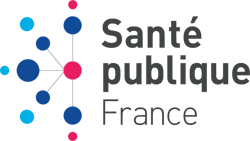</p>
<p>L'agence <strong>"Santé publique France"</strong> a lancé un appel à projets pour trouver des <strong>idées innovantes d’applications en lien avec l'alimentation</strong>.</p>
</div>
</div>
</div>
    </div>

# Objectif :

* comprendre du mieux possible nos donnees
* developper une strategie de modelisation

## Precision du jeux de donnees

* Les informations générales sur la fiche du produit : nom, date de modification, etc.

* Un ensemble de tags : catégorie du produit, localisation, origine, etc.

* Les ingrédients composant les produits et leurs additifs éventuels.

* Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.

## Idee d application

Nous aimerions developper une application pour aider les diabetiques à calculer les glucides necessaires lors de le repas . 

Il s agit du ratio insuline/glucides exprimé sous la forme :

1 unite d insuline / n grammes de glucides

Nous essayerons de calculer un Gluciscore à partir de ces données (A pour fort en glucide à F faible en glucides), ainsi qu un systeme de recommendation
en fonction des besoins des malades du diabete


**Analyse de Forme :**

* variable target : calcul des glucides 
* lignes et colonnes :2051571 lignes , 187 colonnes-> 435465 lignes, 58 colonnes apres nettoyage
* types de variables : qualitative 60 quantitative 127 --> qualitative 35 quantitative 18 apres nettoyage
* analyse des valeurs manquantes : beaucoup de NaN
* uniformisation des formats de dates pour toutes les colonnes contenant une date
 
* 'nutrition-score','nova_group', 'nutrition-score-fr_100g' on des donnees bien reparti
* calcul knn pour completer quelques variables quantitatives


**Analyse de Fond :**

* visualisation de la target







In [1]:
from google.colab import drive
drive.mount('/content/ShardDrives/', force_remount=True)

Mounted at /content/ShardDrives/


In [2]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', None ) #pour afficher toutes les colonnes
pd.set_option('display.max_rows', None ) #pour afficher toutes les lignes

# Analyse univariées

In [4]:
#ici on import le fichier fr.openfoodfacts.org.products.csv
openFoodFile = pd.read_csv("/content/ShardDrives/MyDrive/formation/fr.openfoodfacts.org.products.csv", sep='\t', low_memory=False)

# analyse de la forme des donnees

In [5]:
openFoodFile.shape

(2051571, 187)

In [6]:
#detection des differents type de variable
openFoodFile.dtypes.value_counts()

float64    125
object      60
int64        2
dtype: int64

In [7]:
#on affiche la liste des colonne et leur types
openFoodFile.dtypes

code                                                      object
url                                                       object
creator                                                   object
created_t                                                  int64
created_datetime                                          object
last_modified_t                                            int64
last_modified_datetime                                    object
product_name                                              object
abbreviated_product_name                                  object
generic_name                                              object
quantity                                                  object
packaging                                                 object
packaging_tags                                            object
packaging_text                                            object
brands                                                    object
brands_tags              

In [8]:
# inspection d un echantillon
openFoodFile.sample(5)

code                                                url  \
322833   0210742018762  http://world-fr.openfoodfacts.org/produit/0210...   
851804   3270190204924  http://world-fr.openfoodfacts.org/produit/3270...   
1378446  5060493120284  http://world-fr.openfoodfacts.org/produit/5060...   
1990193  8725000649098  http://world-fr.openfoodfacts.org/produit/8725...   
384647   0651235309286  http://world-fr.openfoodfacts.org/produit/0651...   

                   creator   created_t      created_datetime  last_modified_t  \
322833             kiliweb  1528378804  2018-06-07T13:40:04Z       1528378816   
851804            jeanbono  1371739436  2013-06-20T14:43:56Z       1549140394   
1378446            kiliweb  1570103580  2019-10-03T11:53:00Z       1627986404   
1990193        panieravide  1509293147  2017-10-29T16:05:47Z       1509293149   
384647   org-database-usda  1587671095  2020-04-23T19:44:55Z       1587671095   

        last_modified_datetime  \
322833    2018-06-07T13:40:16Z   
851804    2019-02-02T20:46:34Z   
1378446   2021-08-03T10:26:44Z   
1990193   2017-10-29T16:05:49Z   
384647    2020-04-23T19:44:55Z   

                                              product_name  \
322833                                                Lard   
851804     Brioche tranchée Pur Beurre (18 tranches) 500 g   
1378446                               Square Root Lemonade   
1990193                      Bastaard Appel en Citroengras   
384647   Cheesy mac & chicken a select blend of rotini ...   

        abbreviated_product_name                                 generic_name  \
322833                       NaN                                          NaN   
851804                       NaN  Brioche tranchée pur beurre aux oeufs frais   
1378446                      NaN                                          NaN   
1990193                      NaN                                          NaN   
384647                       NaN                                          NaN   

                    quantity         packaging    packaging_tags  \
322833                   NaN               NaN               NaN   
851804   500 g (18 tranches)  Sachet plastique  sachet-plastique   
1378446               275 ml             glass             glass   
1990193                30 cl               NaN               NaN   
384647                   NaN               NaN               NaN   

        packaging_text       brands  brands_tags  \
322833             NaN          NaN          NaN   
851804             NaN    Carrefour    carrefour   
1378446            NaN  Square Root  square-root   
1990193            NaN   Hertog Jan   hertog-jan   
384647             NaN          NaN          NaN   

                                                categories  \
322833                                                 NaN   
851804   Snacks, Snacks sucrés, Petit-déjeuners, Vienno...   
1378446  Beverages,Carbonated drinks,Sodas,Lemonade,Swe...   
1990193                                                NaN   
384647                                        Frozen foods   

                                           categories_tags  \
322833                                                 NaN   
851804   en:snacks,en:sweet-snacks,en:breakfasts,en:vie...   
1378446  en:beverages,en:carbonated-drinks,en:sodas,en:...   
1990193                                                NaN   
384647                                     en:frozen-foods   

                                             categories_fr  \
322833                                                 NaN   
851804   Snacks,Snacks sucrés,Petit-déjeuners,Viennoise...   
1378446  Boissons,Boissons gazeuses,Sodas,Limonades,Boi...   
1990193                                                NaN   
384647                                            Surgelés   

                                                   origins  \
322833                                                 NaN   
851804   44320 Chauvé,Loire-Atlantique

<a name='vm'></a>
# Analyse des variables manquantes


## on peut remarquer qu ils manquent beaucoup de valeurs manquantes

* **installation de missingno afin d avoir un apercu rapide des valeurs manquantes**

In [ ]:
pip install missingno

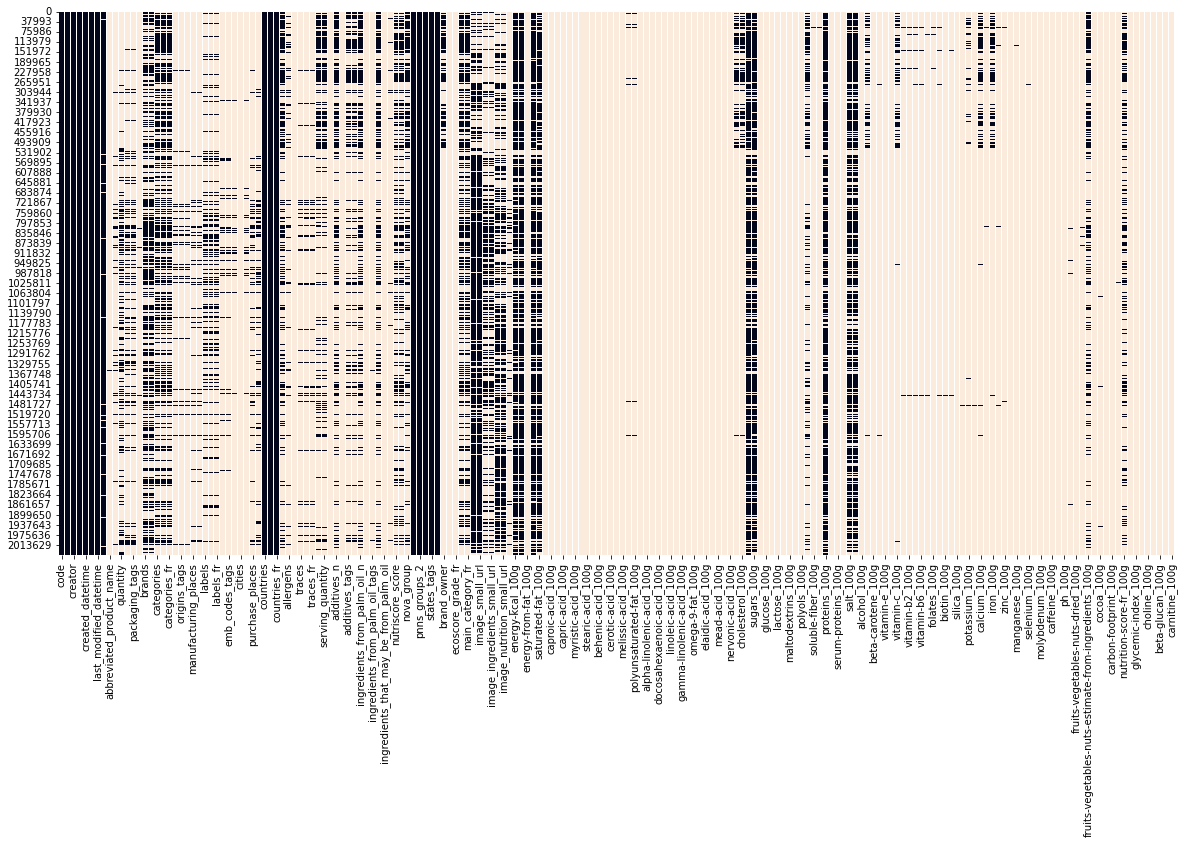

In [ ]:
#on  affiche ici la liste des valeurs manquantes grace a isna()
plt.figure(figsize=(20,10))
sns.heatmap(openFoodFile.isna(), cbar=False)

In [9]:
(openFoodFile.notna().mean(axis=0)*100).sort_values(ascending=False)

code                                                     100.000000
created_t                                                100.000000
states_fr                                                100.000000
states_tags                                              100.000000
last_modified_t                                          100.000000
created_datetime                                         100.000000
states                                                   100.000000
last_modified_datetime                                   100.000000
url                                                      100.000000
creator                                                   99.999805
pnns_groups_2                                             99.995272
pnns_groups_1                                             99.995174
countries                                                 99.698670
countries_tags                                            99.698426
countries_fr                                    

Oups , une variable nommé <code>glycemic-index_100g</code> est parfaite pour notre etude mais elle n est rempli qu'a 0.000195%...


In [10]:
colors = [ '#77CC22','#FF3300','#FF8800','#009900','#FFDD00','#77CC22','#009900','#FF3300','#FF8800','#FFDD00','#77CC22','#009900','#FF3300','#FF8800','#FFDD00','#77CC22','#009900','#FF3300','#FF8800','#FFDD00',
          '#77CC22','#009900','#FF3300','#FF8800','#FFDD00','#77CC22','#009900','#FF3300','#FF8800','#FFDD00','#77CC22','#009900','#FF3300','#FF8800','#FFDD00','#77CC22','#009900','#FF3300','#FF8800','#FFDD00']

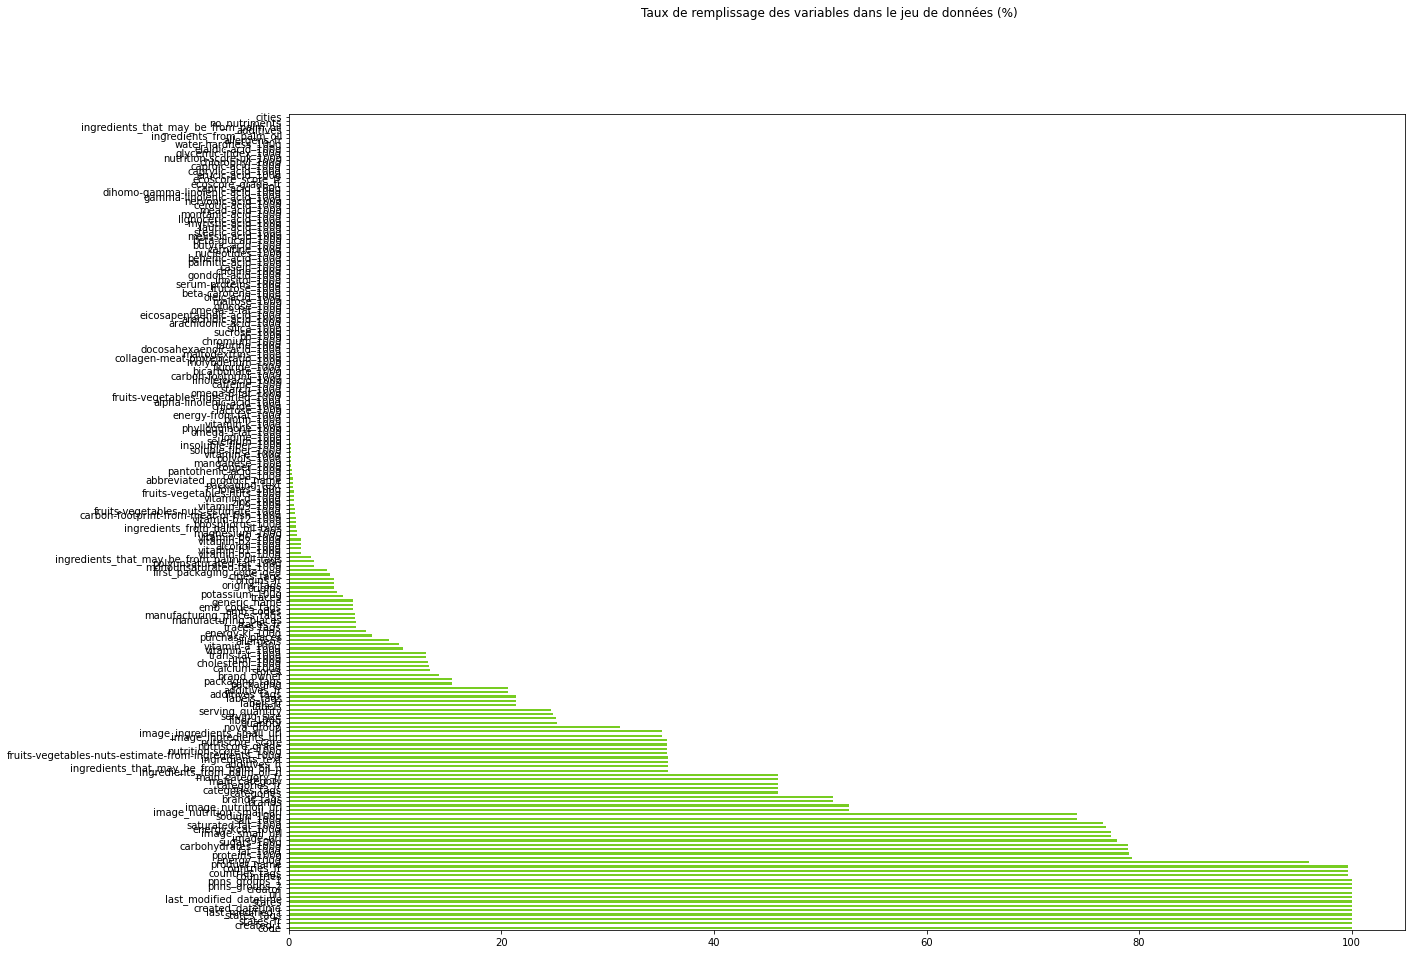

In [ ]:
# plt.style.use('seaborn-white')
sns.set_palette(sns.color_palette(colors))
taux = (openFoodFile.notna().mean(axis=0)*100).sort_values(ascending=False)
plt.suptitle("Taux de remplissage des variables dans le jeu de données (%)")
taux.plot(kind='barh', figsize=(20, 15))

**Apres un coup d oeil rapide on voit clairement que beaucoup de colonnes sont inutiles...**

**Nous allons selectionner les colonnes suffisament rempli, + 15%**

In [11]:
#supression des colonnes avec jeux de donnees manquants
openFoodFile = openFoodFile[openFoodFile.columns[openFoodFile.isna().sum()/openFoodFile.shape[0] < 0.85]]

In [12]:
openFoodFile.shape

(2051571, 58)

<a name='count'></a>
# filtrage pays France

In [13]:
#repartition des aliments par pays
openFoodFile['countries'].value_counts().head(15)

France           435465
United States    310747
en:fr            211675
en:es            106461
en:it            102474
España            87034
en:france         77031
en:us             47364
en:be             34325
en:ca             29356
en:ch             28515
en:FR             26391
en:gb             25330
en:de             22586
Deutschland       21890
Name: countries, dtype: int64

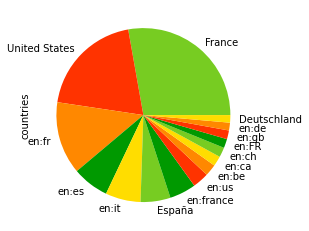

In [ ]:
sns.set_palette(sns.color_palette(colors))
openFoodFile['countries'].value_counts().head(15).plot(kind='pie')

**La selection de l echantillon France est suffisant pour notre analyse**

In [14]:
#selection de l echantillon "France" echantillon suffisant pour notre analyse
openFoodFile[(openFoodFile['countries'] == "France")]['countries'].shape

(435465,)

In [15]:
# selection de la france uniquement
openFoodFile = openFoodFile[(openFoodFile['countries'] == "France")]

## notre jeux de donnees apres suppression de colonnes inexploitable

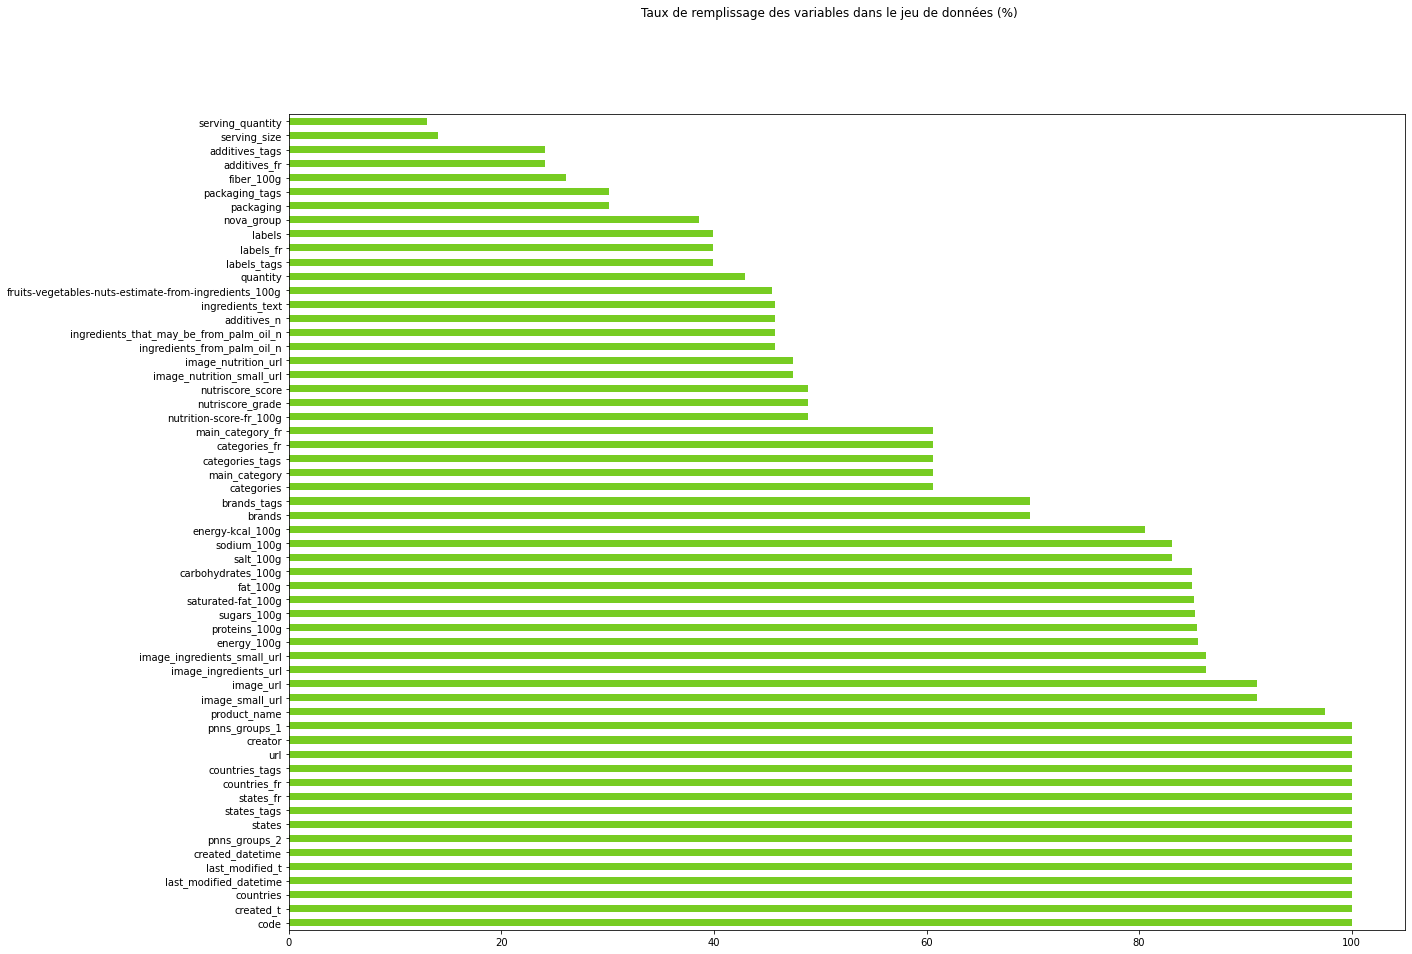

In [ ]:
sns.set_palette(sns.color_palette(colors))
taux = (openFoodFile.notna().mean(axis=0)*100).sort_values(ascending=False)
plt.suptitle("Taux de remplissage des variables dans le jeu de données (%)")
taux.plot(kind='barh', figsize=(20, 15))

**on peut remarquer que les champs**: 
* code
* url
* creator
* les dates
* pnns_groups1
* pnns_groups2

**sont bien rempli a 100%**

* les champs finissant par <code>_100g</code> sont partiellement rempli, mais suffisant pour pouvoir continuez l exploration

<a name='date'></a>
## Mise en forme de nos formats de date 


In [16]:
#mise en forme des formats de date au meme format en fonction de la description des data-fields
#- fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
#- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
openFoodFile.loc[:,'created_t'] = pd.to_datetime(openFoodFile['created_t'], unit='s')
openFoodFile.loc[:,'last_modified_t'] = pd.to_datetime(openFoodFile['last_modified_t'], unit='s')
openFoodFile.loc[:,'created_datetime'] = pd.to_datetime(openFoodFile['created_datetime'])
openFoodFile.loc[:,'last_modified_datetime'] = pd.to_datetime(openFoodFile['last_modified_datetime'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [17]:
openFoodFile[['code','created_t','last_modified_t','created_datetime','last_modified_datetime']].head()

code           created_t     last_modified_t  \
2  0000000000017 2018-06-15 10:38:00 2019-06-25 11:55:18   
3  0000000000031 2018-10-13 21:06:14 2018-10-13 21:06:57   
7  0000000000100 2015-10-11 14:09:21 2015-10-12 14:13:32   
8  0000000000123 2018-08-31 17:53:02 2018-08-31 17:53:06   
9  0000000000178 2018-11-17 12:05:32 2018-11-17 12:05:33   

           created_datetime    last_modified_datetime  
2 2018-06-15 10:38:00+00:00 2019-06-25 11:55:18+00:00  
3 2018-10-13 21:06:14+00:00 2018-10-13 21:06:57+00:00  
7 2015-10-11 14:09:21+00:00 2015-10-12 14:13:32+00:00  
8 2018-08-31 17:53:02+00:00 2018-08-31 17:53:06+00:00  
9 2018-11-17 12:05:32+00:00 2018-11-17 12:05:33+00:00

<a name='valeur_aberrante'></a>
## **analyse de nos donnees, et suppression des valeurs aberrantes et doublons**

In [18]:
openFoodFile.drop_duplicates(inplace=True)

In [19]:
#detection des differents type de variable
openFoodFile.dtypes.value_counts()

object                 36
float64                18
datetime64[ns]          2
datetime64[ns, UTC]     2
dtype: int64

In [20]:
openFoodFile.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity',
       'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories',
       'categories_tags', 'categories_fr', 'labels', 'labels_tags',
       'labels_fr', 'countries', 'countries_tags', 'countries_fr',
       'ingredients_text', 'serving_size', 'serving_quantity', 'additives_n',
       'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'states', 'states_tags', 'states_fr', 'main_category',
       'main_category_fr', 'image_url', 'image_small_url',
       'image_ingredients_url', 'image_ingredients_small_url',
       'image_nutrition_url', 'image_nutrition_small_url', 'energy-kcal_100g',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
      

In [21]:
# affiche du nombre doublons sur la colonne "code" ici , code doit etre unique
openFoodFile[openFoodFile['code'].duplicated() == True].shape

(5, 58)

In [22]:
# ici on effectue une deduplication sur l identifiant theoriquement unique
openFoodFile.drop_duplicates(subset = ['code'],inplace=True)

# nettoyage valeurs aberrante sur les variables quantitatives

Le jeu de données est nettoyé dans les grands axes
* mais il reste un grand nombre de valeurs manquantes 
* mais également des outliers à identifier.

In [23]:
openFoodFile.loc[:,openFoodFile.columns.str.contains('_100') ].describe()

energy-kcal_100g   energy_100g       fat_100g  saturated-fat_100g  \
count      3.508090e+05  3.726940e+05  370221.000000       370858.000000   
mean       2.777092e+02  1.158902e+03      13.971821            5.364750   
std        2.303837e+03  1.314315e+04      50.726019            8.647881   
min        0.000000e+00  0.000000e+00       0.000000            0.000000   
25%        1.110000e+02  4.640000e+02       1.000000            0.200000   
50%        2.600000e+02  1.071000e+03       7.500000            2.000000   
75%        3.970000e+02  1.653000e+03      22.000000            7.800000   
max        1.360000e+06  8.010000e+06   29000.000000         2000.000000   

       carbohydrates_100g    sugars_100g     fiber_100g  proteins_100g  \
count       370149.000000  371321.000000  113389.000000  371901.000000   
mean            27.315922      13.800574       2.878242       8.890519   
std            316.747789      48.634761       4.971527     120.085924   
min             -1.000000      -1.000000       0.000000       0.000000   
25%              2.500000       0.680000       0.100000       1.400000   
50%             13.700000       3.400000       1.600000       6.100000   
75%             52.000000      19.500000       3.500000      12.400000   
max         192000.000000   27000.000000     100.000000   73000.000000   

           salt_100g    sodium_100g  \
count  361805.000000  361804.000000   
mean        1.291029       0.516584   
std        24.036515       9.615010   
min         0.000000       0.000000   
25%         0.060000       0.024000   
50%         0.510000       0.204000   
75%         1.300000       0.520000   
max     14000.000000    5600.000000   

       fruits-vegetables-nuts-estimate-from-ingredients_100g  \
count                                      198127.000000       
mean                                           12.465346       
std                                            52.761810       
min                                             0.000000       
25%                                             0.000000       
50%                                             0.000000       
75%                                             8.510000       
max                                          9997.000000       

       nutrition-score-fr_100g  
count            212817.000000  
mean                  9.289751  
std                   8.796634  
min                 -15.000000  
25%                   2.000000  
50%                  10.000000  
75%                  16.000000  
max                  40.000000

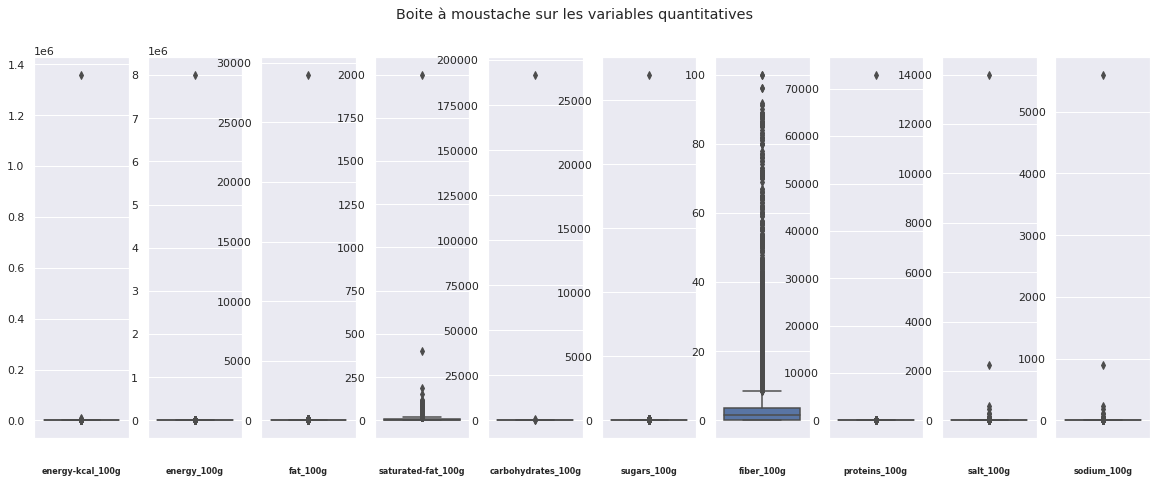

In [24]:
from matplotlib import legend
import numpy as np
import warnings
columntocheck = ['energy-kcal_100g','energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g',]
sns.set_palette(sns.color_palette(colors))
warnings.filterwarnings('ignore')
sns.set(rc = {'figure.figsize':(20,7)})
names = openFoodFile[columntocheck].columns
ncols = len(names)
fig, axes = plt.subplots(1,ncols)

for name, ax in zip(names, axes.flatten()):
    # print(name)
    ax.text(x=0.5, y=-0.1, s=name, fontsize=8, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    # plt.title(name)
    t = sns.boxplot(y=name, data=openFoodFile, orient='v', ax=ax)
    t.set(ylabel=None)
plt.suptitle("Boite à moustache sur les variables quantitatives")  
plt.tight_layout(h_pad=9.0,rect =(0,1,1,0),pad=9.0)

On remarque  que les valeurs minimum et maximum de certaines variables contiennent des valeurs aberrantes, ce qui impacte **l'écart-type et donc la variance.**

In [25]:
openFoodFile.shape

(435459, 58)

<a name="quali"></code>
# analyse des variables qualitatives

**Nous avons vu que la variable <code>pnns_groups_2</code>**

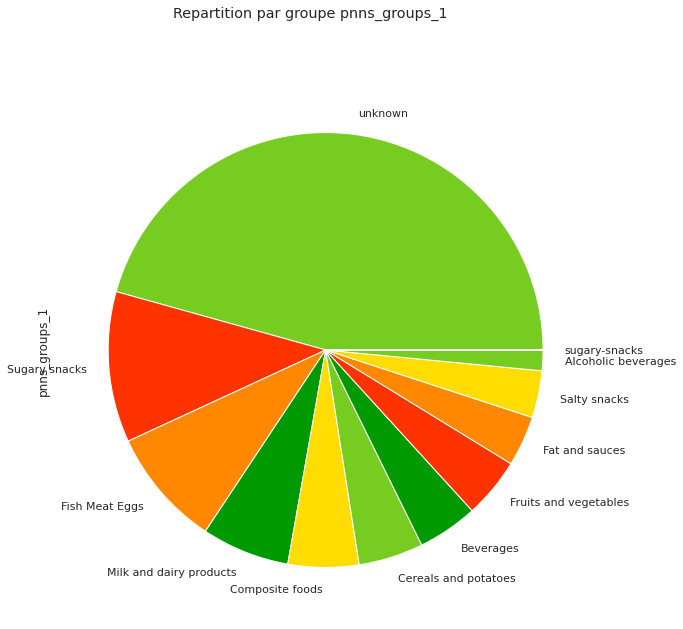

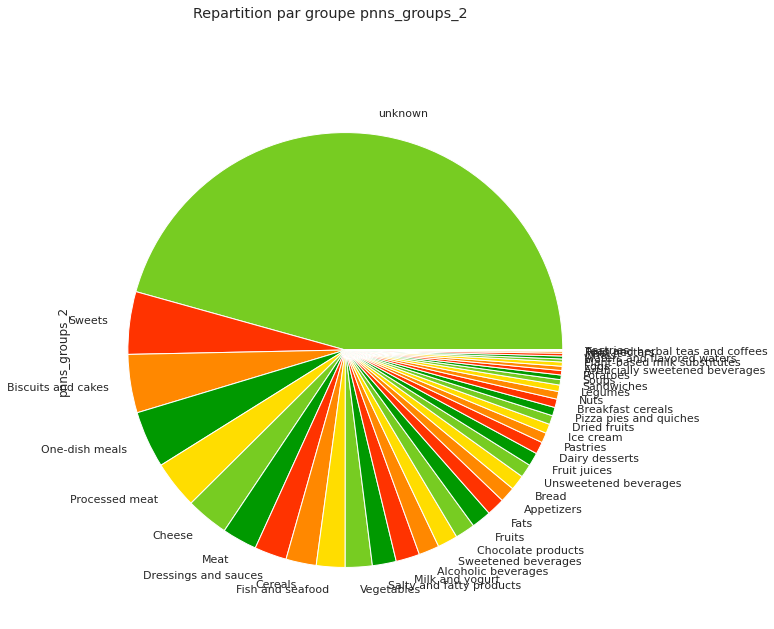

In [ ]:
sns.set_palette(sns.color_palette(colors))
for col in ['pnns_groups_1','pnns_groups_2']:
    plt.figure()
    plt.suptitle("Repartition par groupe {}".format(col))   
    openFoodFile[col].value_counts().plot.pie()
 

In [26]:
openFoodFile_cleaned = openFoodFile

<a name="bag"></a>
# bag of word

In [27]:
openFoodFile_cleaned[['categories_tags','categories','categories_fr','states_tags']][(~openFoodFile_cleaned['categories_tags'].isna())| (openFoodFile_cleaned['categories'].notna())& (openFoodFile_cleaned['categories_fr'].notna())& (openFoodFile_cleaned['states_tags'].notna())].head()

categories_tags  \
7    en:groceries,en:condiments,en:sauces,en:mustards   
16                        en:marzipan,en:almond-paste   
17  en:meals,en:prepared-vegetables,en:grated-carr...   
26              en:pies,en:sweet-pies,en:coconut-pies   
36  en:plant-based-foods-and-beverages,en:plant-ba...   

                                           categories  \
7             Epicerie, Condiments, Sauces, Moutardes   
16                                     Pâtes d'amande   
17  Plats préparés, Légumes préparés, Carottes râp...   
26   Tartes, Tartes sucrées, Tartes à la noix de coco   
36  Aliments et boissons à base de végétaux, Alime...   

                                        categories_fr  \
7                Epicerie,Condiments,Sauces,Moutardes   
16                           Massepain,Pâtes d'amande   
17  Plats préparés,Légumes préparés,Carottes râpée...   
26     Tartes,Tartes sucrées,Tartes à la noix de coco   
36  Aliments et boissons à base de végétaux,Alimen...   

                                          states_tags  
7   en:to-be-completed,en:nutrition-facts-complete...  
16  en:to-be-completed,en:nutrition-facts-complete...  
17  en:to-be-completed,en:nutrition-facts-complete...  
26  en:to-be-completed,en:nutrition-facts-complete...  
36  en:to-be-completed,en:nutrition-facts-complete...

In [28]:
tagsList = ['categories_tags','categories','categories_fr']

In [ ]:
from collections import Counter
from wordcloud import WordCloud
def bagOfWord(data, label='product_name', sep=' '):
    words = []
    
    for string in data[label]:
        list= str(string).split(sep)
        for w in list:
            if (~('nan' in w) and ~(' ' in w)):
                words.append(w)
    count=Counter(words)
        

    wordcloud = WordCloud(width=1080, height=920, colormap='PuBuGn').fit_words(count)
    plt.figure(figsize=(25,15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.show()

categories_tags-----------------------------------


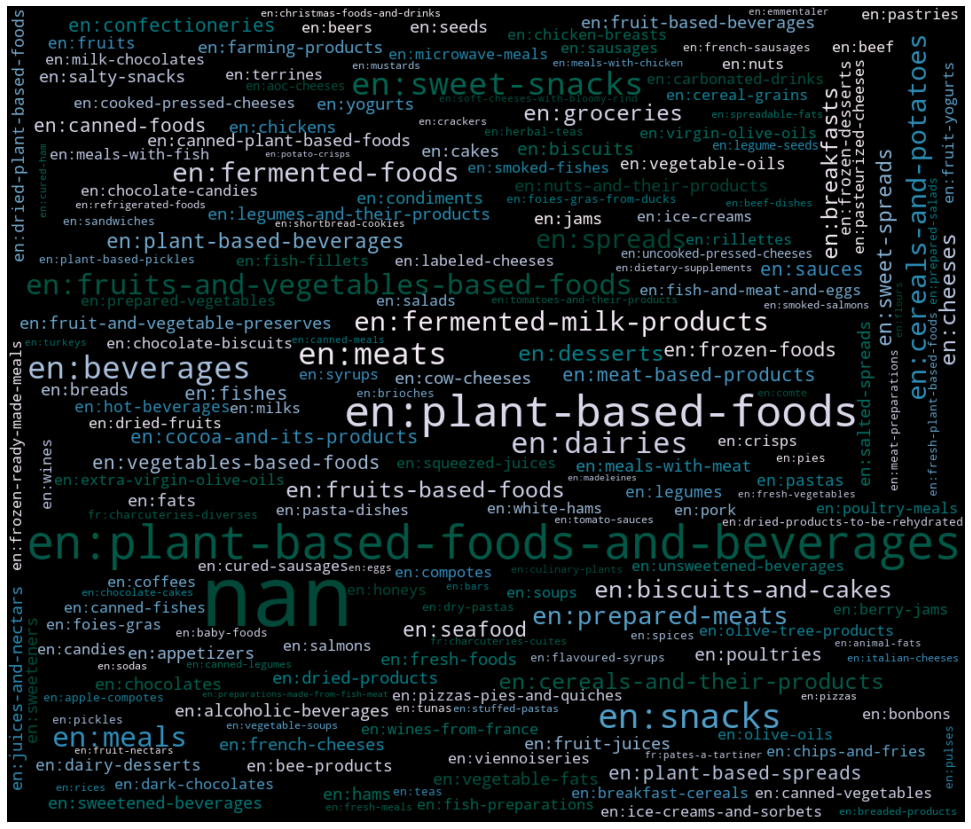

categories----------------------------------------


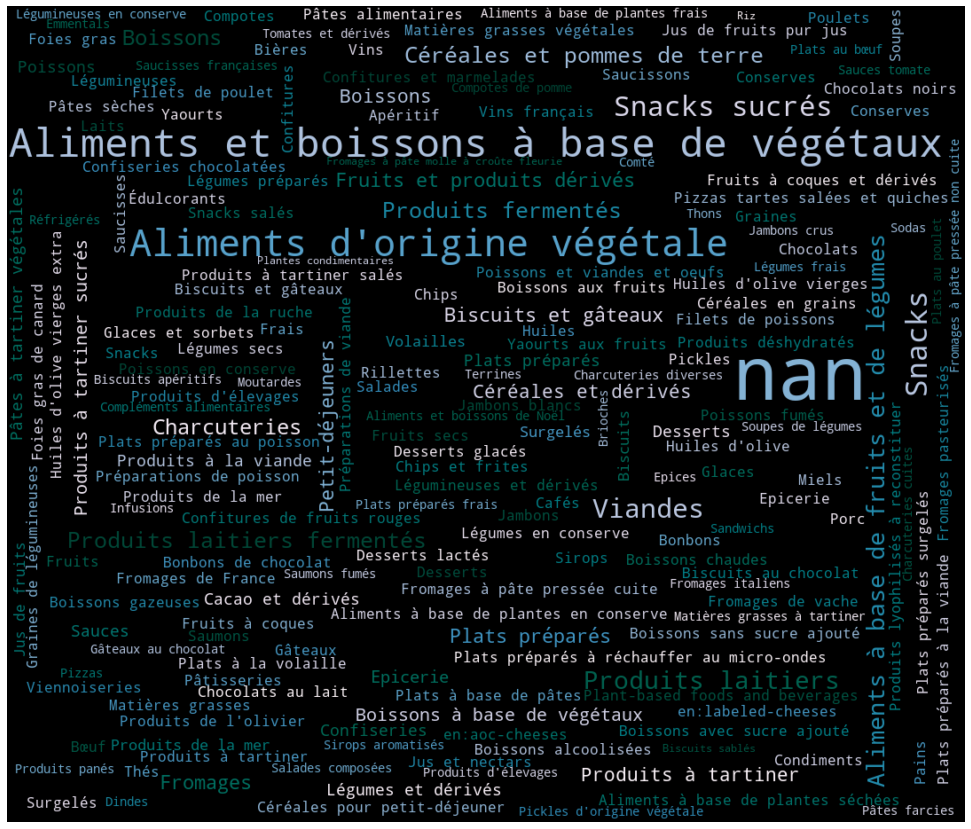

categories_fr-------------------------------------


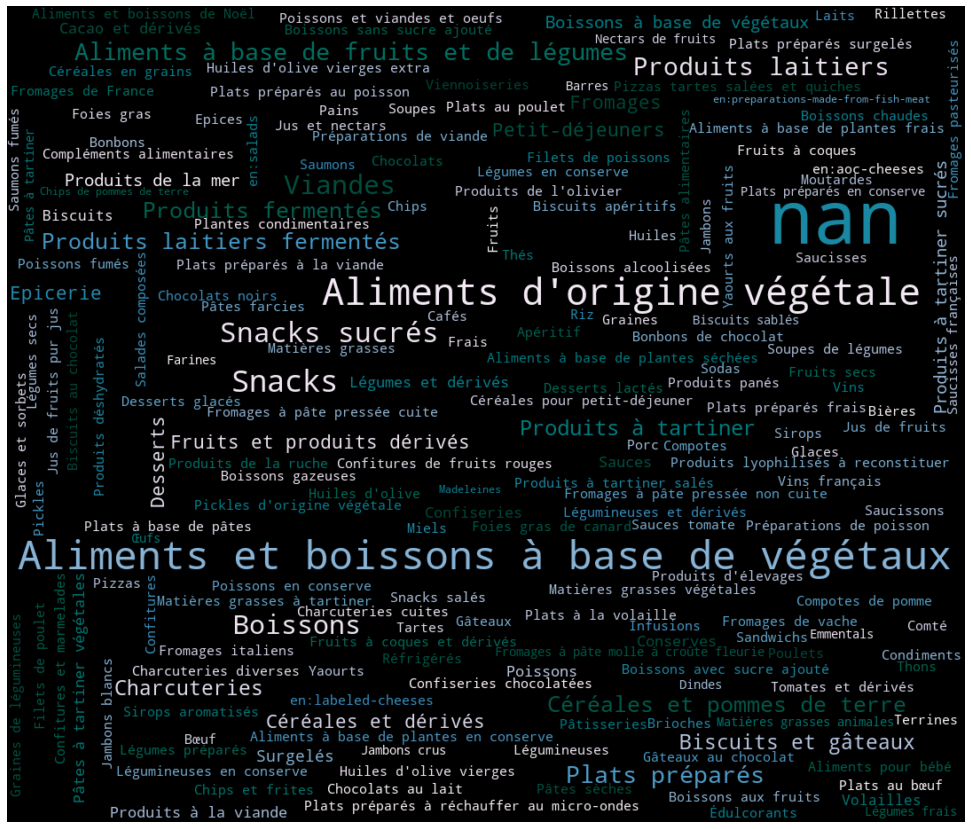

In [ ]:
for col in tagsList:
  print(f'{col:-<50}')
  bagOfWord(openFoodFile_cleaned, label=col, sep=',')

<a name="acp"></a>
# Analyse en Composantes Principales et éboulis des valeurs propres

In [ ]:
# openFoodFile_cleaned.to_csv("/content/ShardDrives/MyDrive/formation/nettoyage5.csv")
# openFoodFile_cleaned = pd.read_csv("/content/ShardDrives/MyDrive/formation/nettoyage5.csv")

In [ ]:
openFoodFile_cleaned.shape

(435459, 58)

In [ ]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from functions import *

In [ ]:
n_comp = 6
acp_vars = openFoodFile_cleaned[['code','energy_100g', 'fat_100g','sugars_100g','saturated-fat_100g','nutriscore_score','fiber_100g','carbohydrates_100g', 'sugars_100g','proteins_100g','salt_100g','sodium_100g']]
acp_vars = acp_vars.dropna()
# keep_ind = X.index
X = acp_vars.values
X.shape
# X

(82772, 12)

In [ ]:
#on sauvegarde donc les intutules des colonnes dans les variables names et features
names = acp_vars["code"]
features = acp_vars.columns

In [ ]:
#centrage et reduction
X_scaled = preprocessing.StandardScaler().fit_transform(X)

In [ ]:
# calcul des composantes principales
pca = decomposition.PCA(n_components=6)
pca.fit(X_scaled)

PCA(n_components=6)

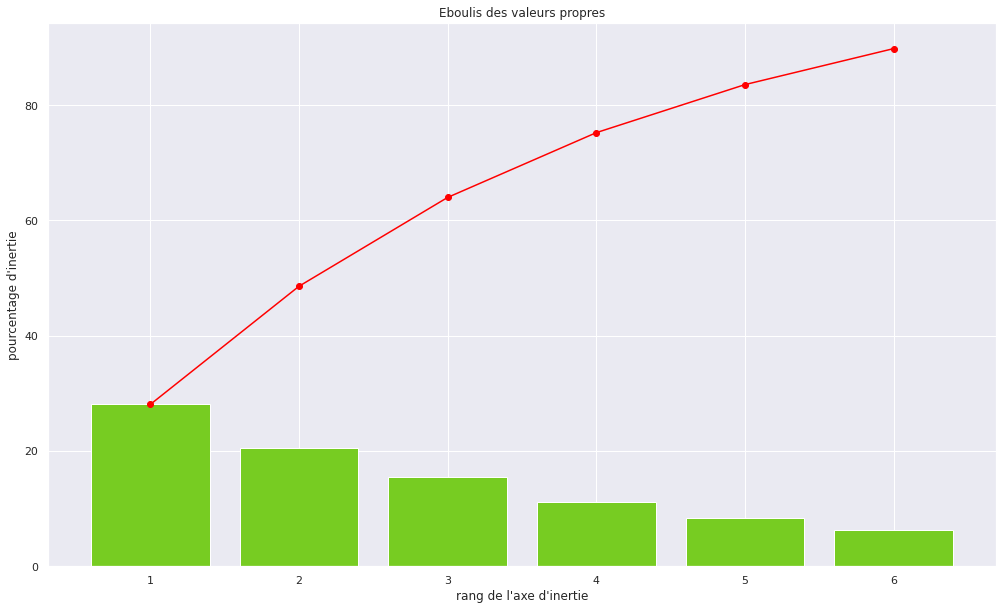

In [ ]:
display_scree_plot(pca)

In [ ]:
pcs = pca.components_

On peut constater que sur le plan F1 les variables suivantes sont correlées : 
  * les fibres et les proteins
  * le nutriscore et l energie
  * les glucides avec le sucres
  * le carbohydrates et le sugar

  Les proteins sont anti correlées avec la sugar et le carbohydrates

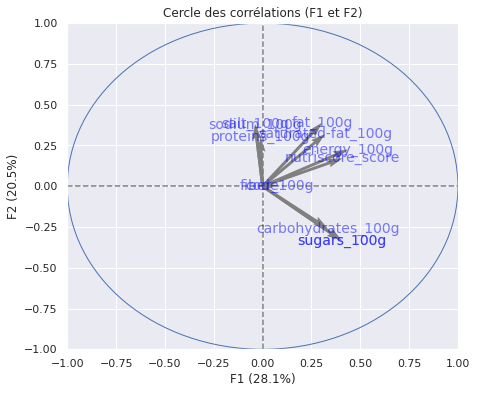

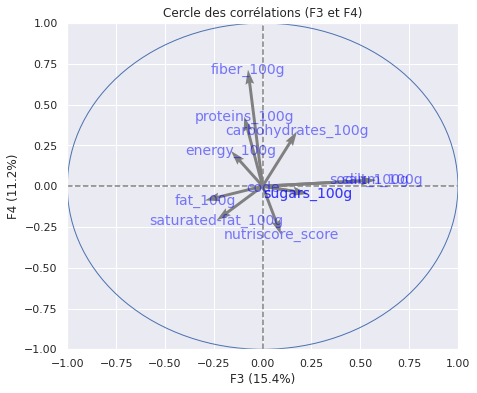

In [ ]:
display_circles(pcs,5,pca,[(0,1),(2,3),(4,5)],labels=np.array(features))

# projection factorielle avec un echantilons des noms des aliments

In [ ]:
n_comp = 6
acp_vars = openFoodFile_cleaned[['product_name','energy_100g', 'fat_100g','sugars_100g','saturated-fat_100g','nutriscore_score','fiber_100g','carbohydrates_100g', 'sugars_100g','proteins_100g','salt_100g','sodium_100g']]
acp_vars = acp_vars.dropna().sample(5000)
# keep_ind = X.index
X = acp_vars.values
X.shape
# X
#on sauvegarde donc les intutules des colonnes dans les variables names et features
names = acp_vars["product_name"]
features = acp_vars.columns
# calcul des composantes principales
pca = decomposition.PCA(n_components=6)
pca.fit(X_scaled)

PCA(n_components=6)

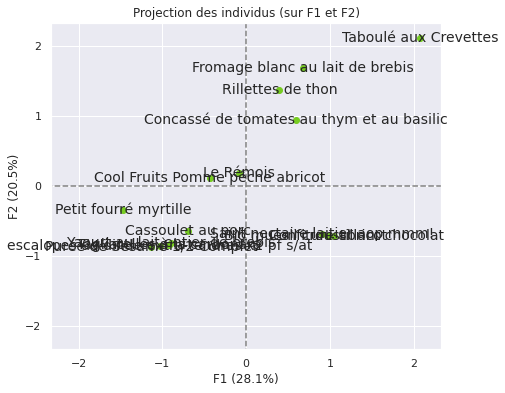

In [ ]:
# acp_vars = acp_vars.dropna().sample(50)
# acp_vars.iloc[:,1:].sample(5)
# keep_ind = X.index
# X = acp_vars.values
X = acp_vars.iloc[:,1:].sample(15).values
#centrage et reduction
X_scaled = preprocessing.StandardScaler().fit_transform(X)
# X_projected = pca.transform(X)
display_factorial_planes(X_scaled, 3, pca, [(0,1),(2,3),(4,5)], labels = np.array(names))
plt.show()

On peut donc remarquer en faisant une projection entre le cercle des correlations et le diagrame de dispersions qu il y a une concentration des aliments dans les zones nutriscore et satured fat

<a name='abb'></a>
## Nettoyage des valeurs nulls ou aberrantes

In [29]:
#On repère les colonnes numeriques
colonnes_num = list(openFoodFile_cleaned.select_dtypes(include=["float64"]).columns)
# #nous ne touchons pas a ces colonnes pour l instant, elle peuvent etre interessant pour la suite de l etude
colonnes_num.remove('nutriscore_score')
colonnes_num.remove('nutrition-score-fr_100g')

In [30]:
#On supprime toutes les lignes dont toutes les colonnes sont nulles ou 0
openFoodFile_cleaned = openFoodFile_cleaned.loc[~((openFoodFile_cleaned[colonnes_num]==0) | (openFoodFile_cleaned[colonnes_num].isnull())).all(axis=1)]

In [31]:
#On supprime les lignes contenant des valeurs négatives et des max aberrants
openFoodFile_cleaned = openFoodFile_cleaned[~(openFoodFile_cleaned[colonnes_num] < 0).any(axis=1)]
openFoodFile_cleaned = openFoodFile_cleaned[~(openFoodFile_cleaned[colonnes_num].isin([999999,9999999])).any(axis=1)]

In [32]:
openFoodFile_cleaned.shape

(382225, 58)

In [33]:
cols_index = [col for col in openFoodFile.columns if '_100' in col]
openFoodFile_cleaned[cols_index].describe()

energy-kcal_100g   energy_100g       fat_100g  saturated-fat_100g  \
count      3.461920e+05  3.680670e+05  366061.000000       366413.000000   
mean       2.814125e+02  1.173465e+03      14.130474            5.429764   
std        2.318924e+03  1.322486e+04      50.991445            8.679815   
min        0.000000e+00  0.000000e+00       0.000000            0.000000   
25%        1.160000e+02  4.810000e+02       1.000000            0.200000   
50%        2.640000e+02  1.088000e+03       7.800000            2.000000   
75%        3.980000e+02  1.661000e+03      22.000000            7.900000   
max        1.360000e+06  8.010000e+06   29000.000000         2000.000000   

       carbohydrates_100g    sugars_100g     fiber_100g  proteins_100g  \
count       365988.000000  366972.000000  112928.000000  367715.000000   
mean            27.626484      13.964129       2.889969       8.991682   
std            318.529826      48.898750       4.978262     120.763742   
min              0.000000       0.000000       0.000000       0.000000   
25%              2.800000       0.700000       0.100000       1.600000   
50%             14.000000       3.500000       1.600000       6.200000   
75%             52.000000      20.000000       3.500000      12.600000   
max         192000.000000   27000.000000     100.000000   73000.000000   

           salt_100g    sodium_100g  \
count  358578.000000  358577.000000   
mean        1.302636       0.521228   
std        24.144117       9.658052   
min         0.000000       0.000000   
25%         0.070000       0.028000   
50%         0.530000       0.212000   
75%         1.300000       0.520000   
max     14000.000000    5600.000000   

       fruits-vegetables-nuts-estimate-from-ingredients_100g  \
count                                      194767.000000       
mean                                           12.680391       
std                                            53.189346       
min                                             0.000000       
25%                                             0.000000       
50%                                             0.000000       
75%                                             9.090909       
max                                          9997.000000       

       nutrition-score-fr_100g  
count            212274.000000  
mean                  9.314560  
std                   8.793727  
min                 -15.000000  
25%                   2.000000  
50%                  10.000000  
75%                  16.000000  
max                  40.000000

**Les variables finissant par  <code>_100g</code> nous indiquent la quantité de nutriment pour 100 grammes de produit. Ces valeurs  ne peuvent logiquement pas depasser 100. Nous supprimons  les lignes dont au moins 1 des variables de nutriments est supérieur**

In [34]:
qt_par_100g = ['carbohydrates_100g','proteins_100g','fat_100g','sugars_100g','salt_100g','sodium_100g','saturated-fat_100g','fiber_100g']
openFoodFile_cleaned = openFoodFile_cleaned[~(openFoodFile_cleaned[qt_par_100g] > 100).any(axis=1)]

In [35]:
openFoodFile_cleaned.shape

(382202, 58)

En se renseignant un peu sur internet on peu remarquer que 
  * les valeurs <code>saturated-fat_100g</code> ne peuvent pas être supérieurs à <code>fat_100g</code>
  * les valeurs <code>sodium_100g</code> ne peuvent pas être supérieurs à <code>salt_100g</code>

In [36]:
openFoodFile_cleaned = openFoodFile_cleaned[~((openFoodFile_cleaned['saturated-fat_100g'] > openFoodFile_cleaned['fat_100g']) 
                                | (openFoodFile_cleaned['sodium_100g'] > openFoodFile_cleaned['salt_100g']))]

In [37]:
openFoodFile_cleaned.shape

(382032, 58)

**Nous avons 188856 produits ne contenant aucune indication de categorie**

**elimination des categories <code>unknow</code> pour les colonnes <code>pnns_groups_1</code> et <code>pnns_groups_2</code>** 

Malheuresement ces categories ne nous reseigne sur pas grand chose, il peut y avoir tous type d aliments differents 

L analyse de ces categories n' est pas pertinant

la categorie <code>unknow</code> est malheuresement inexploitable car elle ne nous indique rien!!

In [38]:
openFoodFile_cleaned[((openFoodFile_cleaned.pnns_groups_1 == "unknown") & 
              (openFoodFile_cleaned.pnns_groups_2 == "unknown"))].shape[0]

163200

In [ ]:
# openFoodFile_cleaned = openFoodFile[~((openFoodFile.product_name.isnull()) 
#                                     & ((openFoodFile.pnns_groups_1 == "unknown") 
#                                     | (openFoodFile.pnns_groups_2 == "unknown")))]

In [39]:
openFoodFile_cleaned = openFoodFile_cleaned[(
                                             (openFoodFile_cleaned.pnns_groups_1 != "unknown")
                                             & (openFoodFile_cleaned.pnns_groups_2 != "unknown")
                                            )]

In [40]:
openFoodFile_cleaned.shape

(218832, 58)

**les densité d'energie maximales pour 100g sont de 3700 kJ/100g**

Supression des lignes dont la variable <code>energy_100g</code> est supérieur à 3700 (ou 900 kcal/100g).

**Conversion de kcal «-» kJ**
Les unités de mesure ont été standardisées avec l’introduction du système international d’unités (SI). Lors de la conversion de kcal (équivalent de 1000 calories) en kJ (1 000 joules), on retient le rapport d'équivalence suivant:

$ 1 kcal = 4,1868 kJ $

$ 1 kJ = 0,2388 kcal $

In [41]:
openFoodFile_cleaned = openFoodFile_cleaned[~((openFoodFile_cleaned['energy_100g'] > 3700) 
                                | (openFoodFile_cleaned['energy-kcal_100g'] > 900))]

In [42]:
openFoodFile_cleaned[qt_par_100g].sample(5)

carbohydrates_100g  proteins_100g  fat_100g  sugars_100g  salt_100g  \
758220                  5.4            0.8       6.0          0.7      1.800   
961745                  0.5            0.6      83.0          0.5      0.000   
721004                  1.5           18.0      13.0          0.5      1.600   
919125                 97.4            0.3       0.1          0.5      0.254   
1952477                 NaN           26.6       1.4          NaN        NaN   

         sodium_100g  saturated-fat_100g  fiber_100g  
758220        0.7200                 3.6         NaN  
961745        0.0000                55.0         NaN  
721004        0.6400                 0.0         NaN  
919125        0.1016                 0.1         0.1  
1952477          NaN                 NaN         NaN

In [ ]:
# openFoodFile_cleaned.to_csv('/content/ShardDrives/MyDrive/formation/nettoyage3.csv')
# openFoodFile = pd.read_csv('../content/ShardDrives/MyDrive/formation/nettoyage2.csv', sep=',', low_memory=False)
# openFoodFile_cleaned=pd.read_csv('/content/ShardDrives/MyDrive/formation/nettoyage3.csv',sep=',') 

In [43]:
openFoodFile_cleaned.shape

(216624, 58)

In [44]:
#suppression des lignes vides pour la liste de colonnes sauf pour fiber_100g
openFoodFile_cleaned = openFoodFile_cleaned[
                                ~(openFoodFile_cleaned['carbohydrates_100g'].isna()
                              & ~(openFoodFile_cleaned['proteins_100g'].isna())
                              & ~(openFoodFile_cleaned['fat_100g'].isna())
                              & ~(openFoodFile_cleaned['sugars_100g'].isna())
                              & ~(openFoodFile_cleaned['salt_100g'].isna())
                              & ~(openFoodFile_cleaned['sodium_100g'].isna())
                              & ~(openFoodFile_cleaned['fat_100g'].isna())
                              )]

In [45]:
openFoodFile_cleaned.shape

(216566, 58)

In [46]:
openFoodFile_cleaned.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity',
       'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories',
       'categories_tags', 'categories_fr', 'labels', 'labels_tags',
       'labels_fr', 'countries', 'countries_tags', 'countries_fr',
       'ingredients_text', 'serving_size', 'serving_quantity', 'additives_n',
       'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'states', 'states_tags', 'states_fr', 'main_category',
       'main_category_fr', 'image_url', 'image_small_url',
       'image_ingredients_url', 'image_ingredients_small_url',
       'image_nutrition_url', 'image_nutrition_small_url', 'energy-kcal_100g',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
      

# notre boite à moustache après cleanage

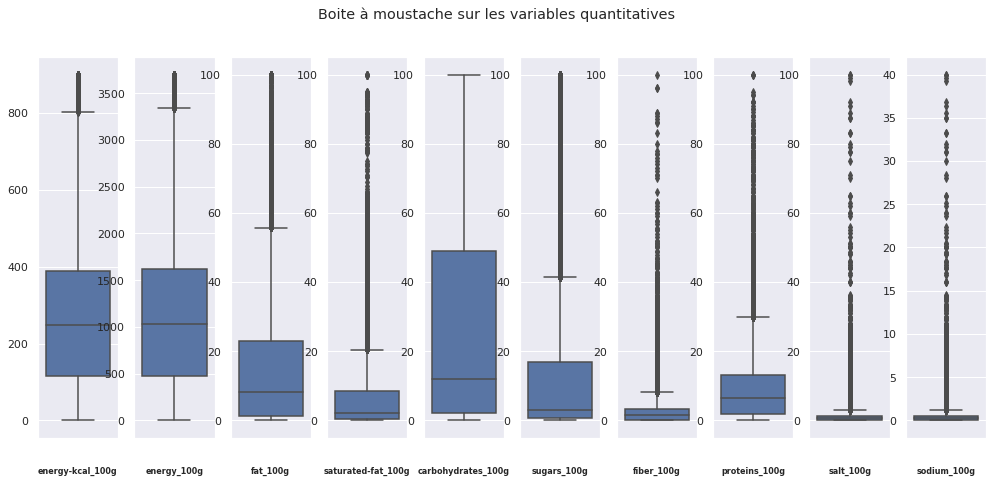

In [47]:
from matplotlib import legend
import numpy as np
import warnings
columntocheck = ['energy-kcal_100g','energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g',]
sns.set_palette(sns.color_palette(colors))
warnings.filterwarnings('ignore')
sns.set(rc = {'figure.figsize':(17,7)})
names = openFoodFile_cleaned[columntocheck].columns
ncols = len(names)
fig, axes = plt.subplots(1,ncols)

for name, ax in zip(names, axes.flatten()):
    # print(name)
    ax.text(x=0.5, y=-0.1, s=name, fontsize=8, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    # plt.title(name)
    t = sns.boxplot(y=name, data=openFoodFile_cleaned, orient='h', ax=ax)
    t.set(ylabel=None)
plt.suptitle("Boite à moustache sur les variables quantitatives")  
plt.tight_layout(h_pad=9.0,rect =(1,1,0,0))



<a name="qt"></a>
# Analyse univariée sur les variables quantitatives

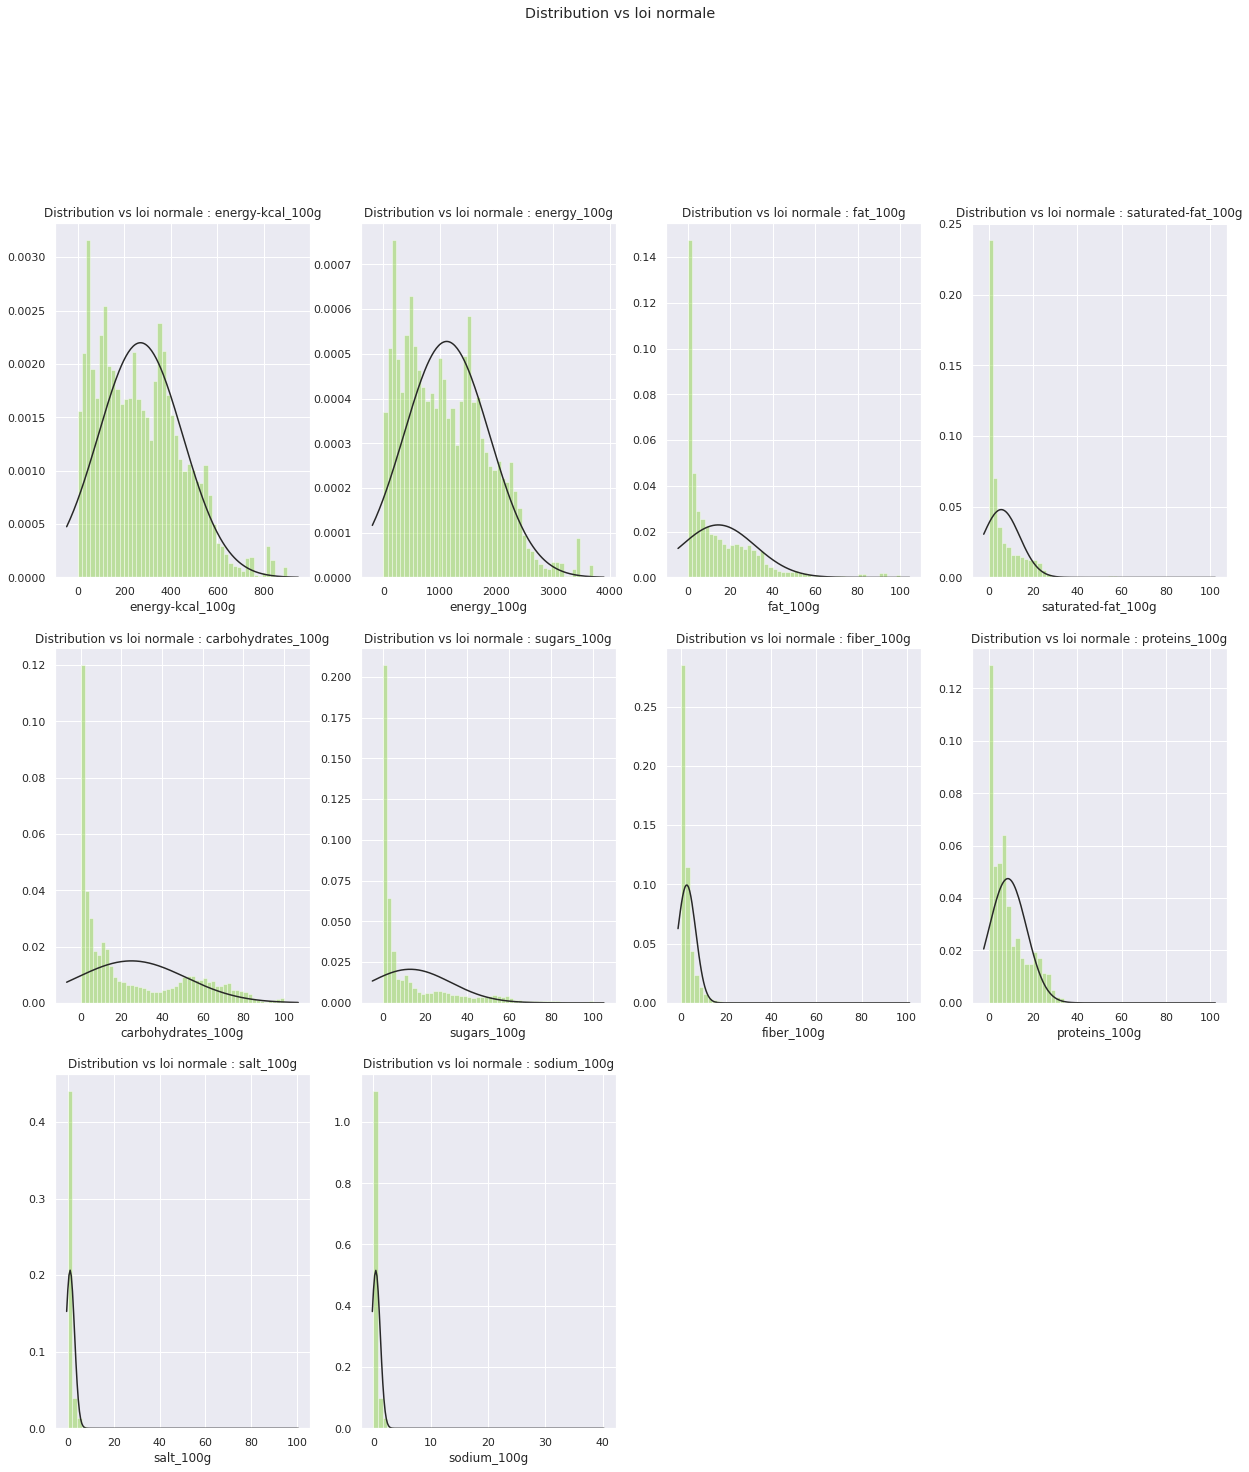

In [ ]:
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
quantitative_col = [
 'energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 ]
sns.set_palette(sns.color_palette(colors))
fig = plt.figure(figsize=(21,30))

sub = 0
for i in range(len(quantitative_col)):
    fig.add_subplot(4,4,i+1)
    colonne = quantitative_col[i]
    # print(colonne)
    # print(openFoodFile_cleaned[colonne].notnull().head())
    kstest = stats.kstest(openFoodFile_cleaned[colonne].notnull(),'norm')
    ax = sns.distplot(openFoodFile_cleaned[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    sub += 1
plt.suptitle("Distribution vs loi normale ")       
plt.show()

# CONNAÎTRE LES GLUCIDES ET LES ALIMENTS QUI EN CONTIENNENT
## LES GLUCIDES
Vous le savez sûrement, les glucides sont d’importants constituants alimentaires qui
fournissent de l’énergie au corps humain. Parmi les glucides, on dénombre :
Les sucres :
* glucose
* fructose : le sucre contenu dans les fruits et légumes
* lactose : le sucre contenu dans le lait
* sucrose (ou saccharose) : le sucre de table, ou sucre blanc.
Certains de ces sucres sont naturellement présents dans les aliments tandis que d’autres ont été ajoutés aux produits alimentaires lors de leur transformation.

## Les glucides complexes :
* L’amidon : de longues chaînes de glucose qui se trouvent dans les aliments féculents **(malheuresement starch_100g correspondant a l amidon n est pas bien represente dans notre jeux de donnees)**
* Les fibres: des glucides non digérés par l’humain, présents dans les produits
céréaliers à grains entiers, les fruits, les légumes et les légumineuses.

## Dans le calcul des glucides, il est recommandé de soustraire, du nombre total de glucides, seulement la moitié (50%) de la quantité de sucres-alcools déclarée sur l’étiquette

In [48]:
openFoodFile_cleaned.shape

(216566, 58)

In [49]:
openFoodFile_cleaned['glucide_100g'] = openFoodFile_cleaned['carbohydrates_100g'].fillna(0) - ( openFoodFile_cleaned['sugars_100g'].fillna(0)/2) - openFoodFile_cleaned['fiber_100g'].fillna(0)

In [50]:
openFoodFile_cleaned['glucide_100g'].describe()

count    216566.000000
mean         16.473247
std          20.424893
min         -88.750000
25%           0.650000
50%           6.100000
75%          28.750000
max         100.000000
Name: glucide_100g, dtype: float64

In [51]:
# #resultat apres nettoyage
wrong_index_100 = openFoodFile_cleaned[(openFoodFile_cleaned['glucide_100g'] > 100) | (openFoodFile_cleaned['glucide_100g'] < 0)].index
wrong_index_100
#suppression des valeurs aberrantes inferieur a 0 g ou superieur a 100
openFoodFile_cleaned = openFoodFile_cleaned.drop(wrong_index_100)

In [52]:
openFoodFile_cleaned['glucide_100g'].describe()

count    209558.000000
mean         17.140664
std          20.386801
min           0.000000
25%           0.900000
50%           6.700000
75%          29.500000
max         100.000000
Name: glucide_100g, dtype: float64

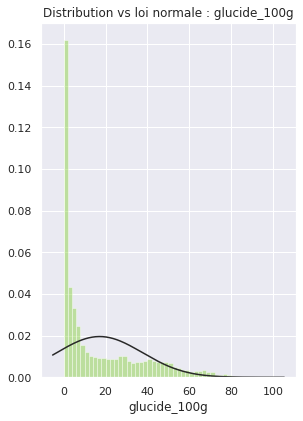

In [53]:
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
quantitative_col = ['glucide_100g']
sns.set_palette(sns.color_palette(colors))
fig = plt.figure(figsize=(21,30))

sub = 0
for i in range(len(quantitative_col)):
    fig.add_subplot(4,4,i+1)
    colonne = quantitative_col[i]
    # print(colonne)
    # print(openFoodFile_cleaned[colonne].notnull().head())
    kstest = stats.kstest(openFoodFile_cleaned[colonne].notnull(),'norm')
    ax = sns.distplot(openFoodFile_cleaned[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    sub += 1
plt.show()

In [54]:
# summarize the number of rows with missing values for each column
quantitative_col = [
 'energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 ]
for i in quantitative_col:
    # count number of rows with missing values
    n_miss = openFoodFile_cleaned[i].isna().sum()
    perc = n_miss / openFoodFile_cleaned.shape[0] * 100
    # print( n_miss, {perc:.2f} '%') 
    # print(f' colonne {i} a {perc} % de valeur manquantes ')
    print(f'La colonne {i:-<70} a {perc:.2f} % de valeur manquantes à traiter')

La colonne energy-kcal_100g------------------------------------------------------ a 13.88 % de valeur manquantes à traiter
La colonne energy_100g----------------------------------------------------------- a 5.28 % de valeur manquantes à traiter
La colonne fat_100g-------------------------------------------------------------- a 5.35 % de valeur manquantes à traiter
La colonne saturated-fat_100g---------------------------------------------------- a 5.91 % de valeur manquantes à traiter
La colonne carbohydrates_100g---------------------------------------------------- a 5.33 % de valeur manquantes à traiter
La colonne sugars_100g----------------------------------------------------------- a 5.75 % de valeur manquantes à traiter
La colonne fiber_100g------------------------------------------------------------ a 65.43 % de valeur manquantes à traiter
La colonne proteins_100g--------------------------------------------------------- a 5.41 % de valeur manquantes à traiter
La colonne salt_100g--

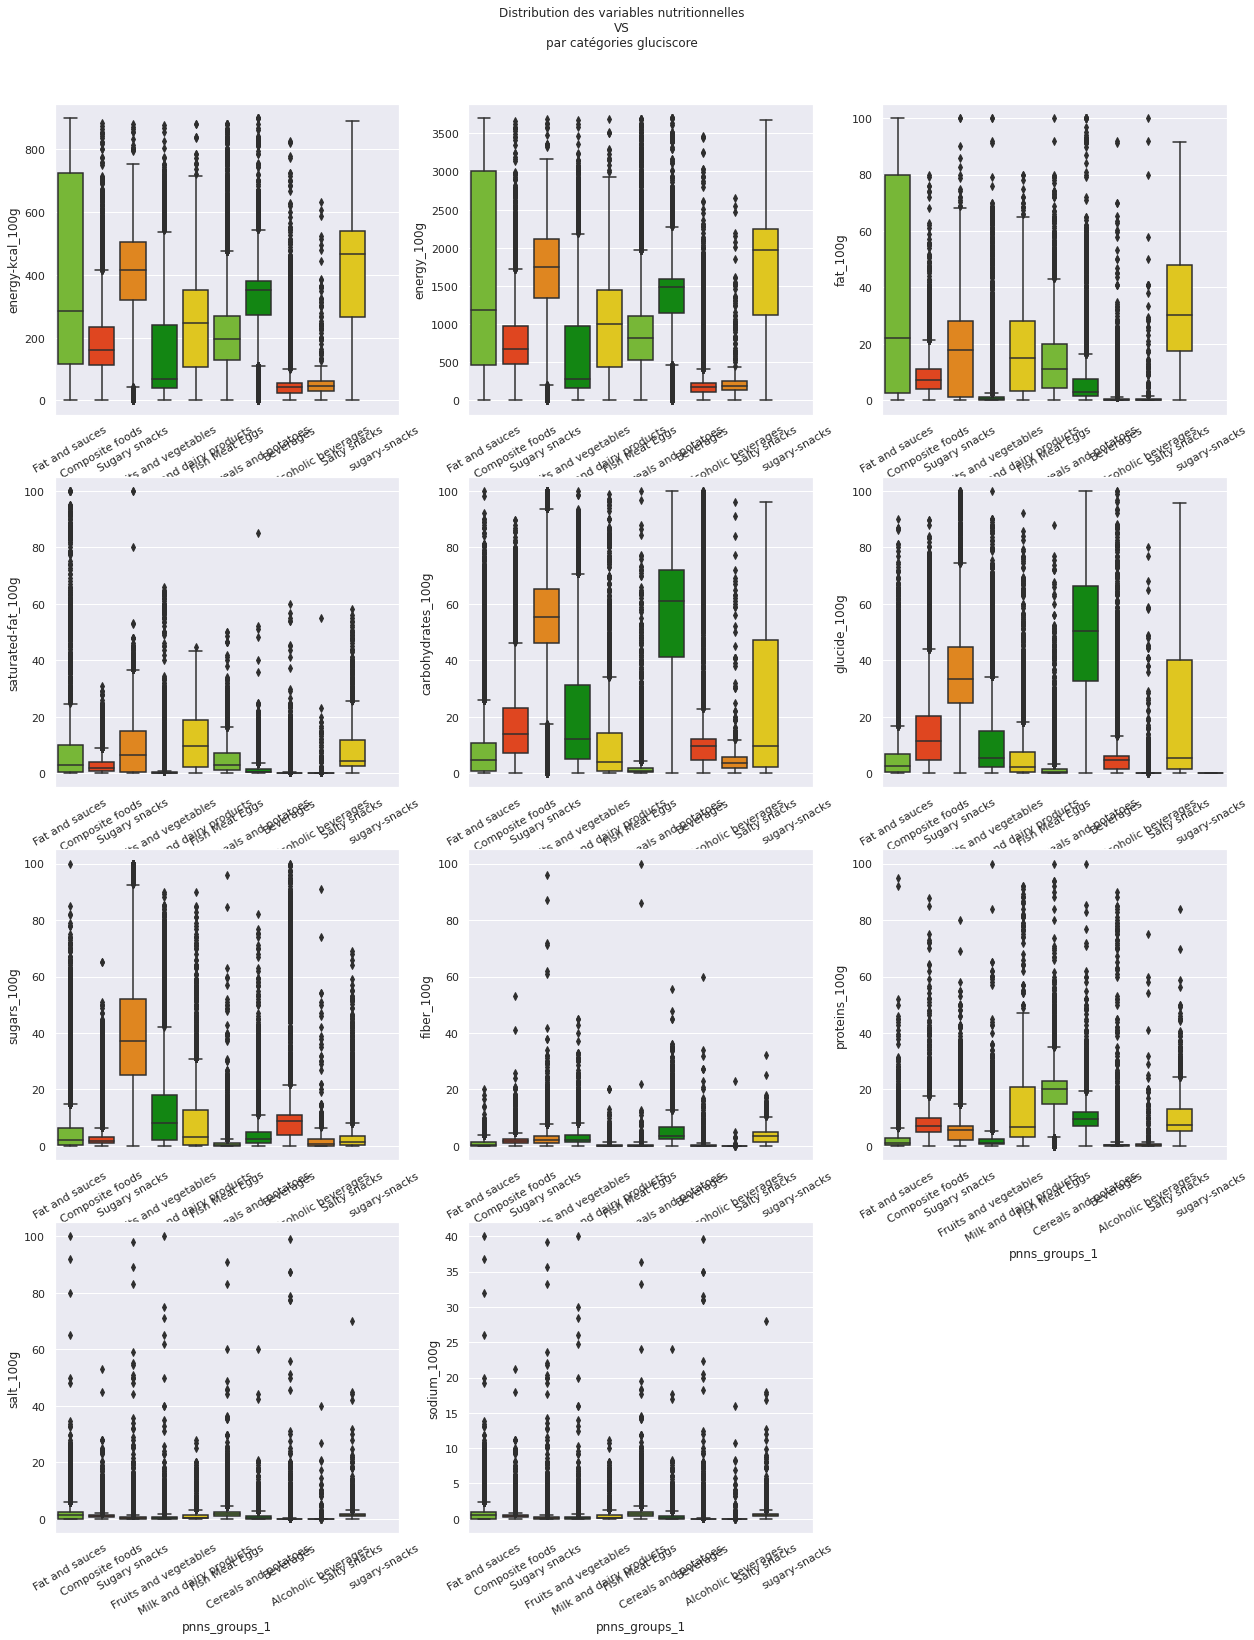

In [57]:
sns.set_palette(sns.color_palette(colors))
fig = plt.figure(figsize=(21,40))
columntocheck = [
 'energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'glucide_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 ]
sub = 0
for i in range(len(columntocheck)):
    fig.add_subplot(6,3,i+1)
    col = columntocheck[i]
    ax = sns.boxplot(x="pnns_groups_1", y=col, data=openFoodFile_cleaned)
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    sub += 1

fig.text(0.5, 0.90, r"Distribution des variables nutritionnelles" "\n" "VS" "\n" "par catégories pnns_groups_1", ha="center")
plt.show()

**On remarque ici que les repartions des variables quantitatives sur <code>pnns_group1</code> sont differents, ils ne suivent pas une loi normale**

<a name="Smirnov"></a>
#  Test de normalité Kolmogorov Smirnov

**Le test de normalité Kolmogorov Smirnov nous indique que les distributions ne sont pas normal**





In [56]:
from scipy import stats
numeric_columns = openFoodFile.select_dtypes('float64').columns
numeric_columns = numeric_columns[1:]

for column in numeric_columns:
    print('________\n{}'.format(column))
    D, p = stats.kstest(openFoodFile[column].dropna(), 
                     'norm', 
                     args=(openFoodFile[column].mean(), openFoodFile[column].std()))
    alpha = 5e-2
    print("p = {}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected : {} is not from a normal distribution".format(column))
    else:
        print("The null hypothesis cannot be rejected")

________
additives_n
p = 0.0
The null hypothesis can be rejected : additives_n is not from a normal distribution
________
ingredients_from_palm_oil_n
p = 0.0
The null hypothesis can be rejected : ingredients_from_palm_oil_n is not from a normal distribution
________
ingredients_that_may_be_from_palm_oil_n
p = 0.0
The null hypothesis can be rejected : ingredients_that_may_be_from_palm_oil_n is not from a normal distribution
________
nutriscore_score
p = 0.0
The null hypothesis can be rejected : nutriscore_score is not from a normal distribution
________
nova_group
p = 0.0
The null hypothesis can be rejected : nova_group is not from a normal distribution
________
energy-kcal_100g
p = 0.0
The null hypothesis can be rejected : energy-kcal_100g is not from a normal distribution
________
energy_100g
p = 0.0
The null hypothesis can be rejected : energy_100g is not from a normal distribution
________
fat_100g
p = 0.0
The null hypothesis can be rejected : fat_100g is not from a normal distribut

<a name="fish"></a>
# Test de Fischer

# Nous allons faire une analyse de la variance(test de fisher) afin de calculer leur ecarts :

La forme générale de l'analyse de variance repose sur la normalité des distributions et l'indépendance des échantillons(test de Fisher).

In [69]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
sous_echantillon = openFoodFile_cleaned[
                                          (openFoodFile_cleaned['energy_100g'].notna()) &
                                          (openFoodFile_cleaned['fat_100g'].notna()) &
                                          (openFoodFile_cleaned['carbohydrates_100g'].notna()) &
                                          (openFoodFile_cleaned['sugars_100g'].notna()) &
                                          (openFoodFile_cleaned['fiber_100g'].notna()) &
                                          (openFoodFile_cleaned['proteins_100g'].notna()) &
                                          (openFoodFile_cleaned['salt_100g'].notna()) &
                                          (openFoodFile_cleaned['sodium_100g'].notna()) &
                                          (openFoodFile_cleaned['nutrition-score-fr_100g'].notna()) 
                                        ]
columntocheck = [
 'energy_100g',
 'fat_100g',
 'carbohydrates_100g',
 'glucide_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 ]
for col in columntocheck:
  print('{}~pnns_groups_1'.format(col))
  t = '{}~pnns_groups_1'.format(col)
  anova_category = smf.ols(t, data=sous_echantillon).fit()
  print(sm.stats.anova_lm(anova_category, typ=2))

energy_100g~pnns_groups_1
                     sum_sq       df            F  PR(>F)
pnns_groups_1  1.938269e+10      9.0  7838.241683     0.0
Residual       1.913289e+10  69635.0          NaN     NaN
fat_100g~pnns_groups_1
                     sum_sq       df            F  PR(>F)
pnns_groups_1  5.644033e+06      9.0  3959.876044     0.0
Residual       1.102790e+07  69635.0          NaN     NaN
carbohydrates_100g~pnns_groups_1
                     sum_sq       df             F  PR(>F)
pnns_groups_1  3.016980e+07      9.0  12318.021301     0.0
Residual       1.895032e+07  69635.0           NaN     NaN
glucide_100g~pnns_groups_1
                     sum_sq       df             F  PR(>F)
pnns_groups_1  1.839337e+07      9.0  10509.663808     0.0
Residual       1.354122e+07  69635.0           NaN     NaN
sugars_100g~pnns_groups_1
                     sum_sq       df            F  PR(>F)
pnns_groups_1  1.159176e+07      9.0  8649.332267     0.0
Residual       1.036936e+07  69635.0          N

Le test de fisher nous montrent que nos p-value pour l ensemble de nos variables sont à 0 inferieur aux limites de 5%.

L hypothese H0 est erronné , nos distributions ne sont pas identiques

Nous pouvons donc dire que **<code>pnns_group1</code> a une influence sur nos variables quantitative <code> 'energy_100g','fat_100g','carbohydrates_100g','glucide_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g'</code>** 


<a name="anova"></a>
# Analyse de la variance avec ANOVA



Comme nous l avons vu ci-dessus nos distributions ne sont pas normales on pourra utiliser les variantes non paramétriques de l'analyse de variance (ANOVA de kruskal wallis)

In [75]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import kruskal
columntocheck = [
 'energy_100g',
 'fat_100g',
 'carbohydrates_100g',
 'glucide_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 ]
t = openFoodFile_cleaned[
                                          (openFoodFile_cleaned['energy_100g'].notna()) &
                                          (openFoodFile_cleaned['fat_100g'].notna()) &
                                          (openFoodFile_cleaned['carbohydrates_100g'].notna()) &
                                          (openFoodFile_cleaned['sugars_100g'].notna()) &
                                          (openFoodFile_cleaned['fiber_100g'].notna()) &
                                          (openFoodFile_cleaned['proteins_100g'].notna()) &
                                          (openFoodFile_cleaned['salt_100g'].notna()) &
                                          (openFoodFile_cleaned['sodium_100g'].notna()) &
                                          (openFoodFile_cleaned['nutrition-score-fr_100g'].notna()) 
                                        ]
# Kruskal-Wallis H-test


# compare samples
stat, p = kruskal(t['energy_100g'], t['fat_100g'], t['carbohydrates_100g'],t['sugars_100g'],t['fiber_100g'],t['proteins_100g'],t['salt_100g'],t['sodium_100g'],t['nutrition-score-fr_100g'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=339318.146, p=0.000
Different distributions (reject H0)


**Les distributions ne sont pas les mêmes**

In [ ]:
# openFoodFile_cleaned.to_csv("/content/ShardDrives/MyDrive/formation/nettoyage5.csv")
# openFoodFile_cleaned = pd.read_csv("/content/ShardDrives/MyDrive/formation/nettoyage5.csv")

<a name="corr"></a>
# Analyse des corrélations linéaires

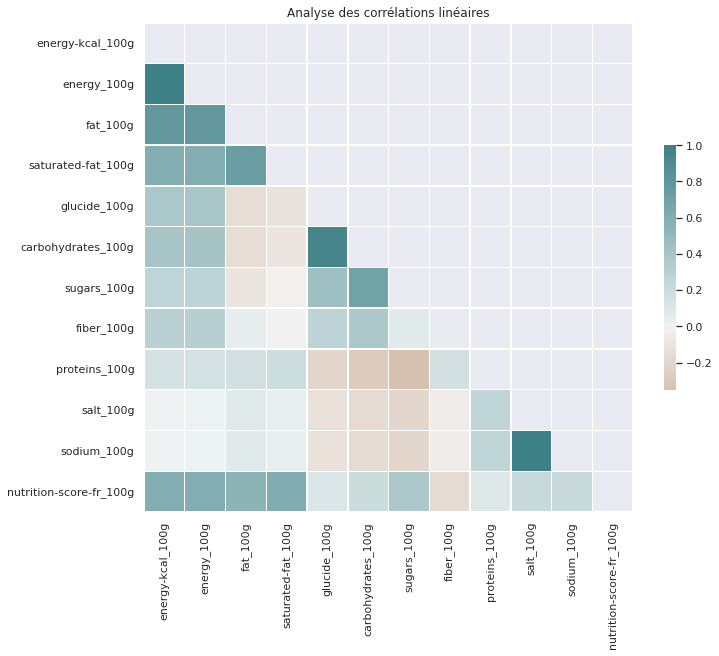

In [ ]:
corr = openFoodFile_cleaned[[               
       'energy-kcal_100g', 
       'energy_100g', 
       'fat_100g',
       'saturated-fat_100g',
       'glucide_100g',
       'carbohydrates_100g', 
       'sugars_100g', 
       'fiber_100g', 
       'proteins_100g',
       'salt_100g',
       'sodium_100g',
       'nutrition-score-fr_100g'
]].corr()
mask = np.triu(np.ones_like(corr,dtype=bool))
# set matplolib
f,ax = plt.subplots(figsize=(11,9))
cmap=sns.diverging_palette(400,200,as_cmap=True)
ax.set_title("Analyse des corrélations linéaires")
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=1, center=0,square=True,linewidths=.5,cbar_kws={"shrink":.5})

**Comme l analyse ANOVA nous l a montrer , on voit clairement des relations entre les variables quantitatives**, en voici certaines

* energy_100g VS energy-kcal_100g (logique)

* fat_100g VS energy-kcal_100g

* salt_100g VS sodium

<a name="knn"></a>
## KNN imputer

<code>fiber_100g</code> est mal renseigner , mais reste indispensable pour l etude. Nous allons remplacer remplacer les valeurs null par la mediane <code>pnns_groups_2</code> car il est remplis a 100%


**Pour les autres variables correctement rempli nous allons leur appliquer l algorithme knn imputers**

In [ ]:
# utilisation de l algorithme knn
from sklearn.impute import KNNImputer

# Entrainement sur un échantillon de données
knn_col = ['energy_100g','proteins_100g','saturated-fat_100g','sugars_100g','salt_100g','carbohydrates_100g','sodium_100g','fat_100g']
sample_datas = openFoodFile_cleaned[knn_col].sample(frac=0.20, random_state=1)
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
imputer.fit(sample_datas)

KNNImputer()

In [ ]:
# application du modele sur les donnees
datas_imputed = imputer.transform(openFoodFile_cleaned[knn_col])
df_datas_imputed = pd.DataFrame(datas_imputed, columns=knn_col)

In [ ]:
#nous enregistrons ces valeurs predites dans une nouvelle colonnes
#nous utiliserons une naming convention suivante :
# pred_columnName
for col in knn_col:
    openFoodFile_cleaned['pred_'+col] = df_datas_imputed[col].values

In [ ]:
openFoodFile_cleaned.columns.sort_values(ascending=False)

Index(['url', 'sugars_100g', 'states_tags', 'states_fr', 'states',
       'sodium_100g', 'serving_size', 'serving_quantity', 'saturated-fat_100g',
       'salt_100g', 'quantity', 'proteins_100g', 'product_name',
       'pred_sugars_100g', 'pred_sodium_100g', 'pred_saturated-fat_100g',
       'pred_salt_100g', 'pred_proteins_100g', 'pred_fat_100g',
       'pred_energy_100g', 'pred_carbohydrates_100g', 'pnns_groups_2',
       'pnns_groups_1', 'packaging_tags', 'packaging',
       'nutrition-score-fr_100g', 'nutriscore_score', 'nutriscore_grade',
       'nova_group', 'main_category_fr', 'main_category', 'last_modified_t',
       'last_modified_datetime', 'labels_tags', 'labels_fr', 'labels',
       'ingredients_that_may_be_from_palm_oil_n', 'ingredients_text',
       'ingredients_from_palm_oil_n', 'image_url', 'image_small_url',
       'image_nutrition_url', 'image_nutrition_small_url',
       'image_ingredients_url', 'image_ingredients_small_url', 'glucide_100g',
       'fruits-vegetable

In [ ]:
# On complète la variables restantes  fiber_100g avec la médiane du groupe pnns 2
openFoodFile_cleaned['med_fiber_100g'] =  openFoodFile_cleaned.groupby('pnns_groups_2')['fiber_100g'].transform(lambda x: x.fillna(x.median()))

## on peut constater que la distribution des variables quantitatives n a pas changer

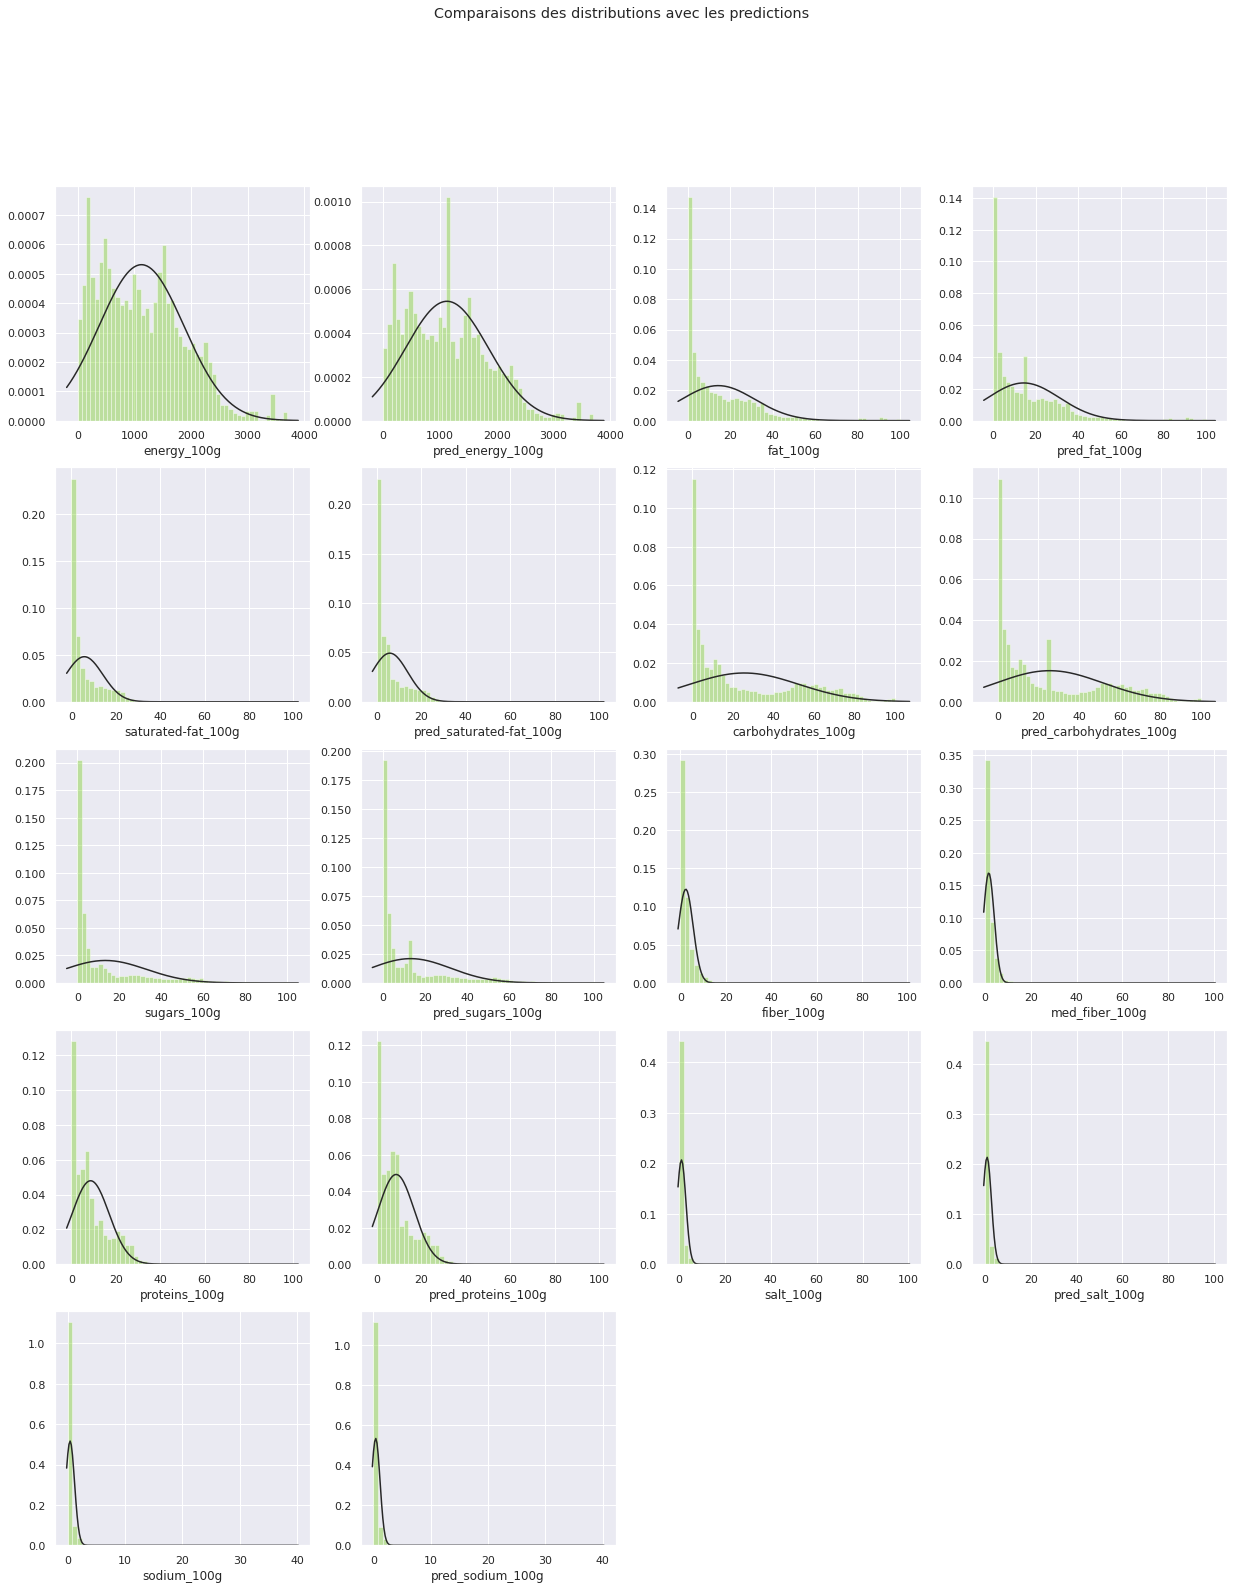

In [ ]:
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
predicted_features = [
 'energy_100g',
 'pred_energy_100g',
 'fat_100g',
 'pred_fat_100g',
 'saturated-fat_100g',
 'pred_saturated-fat_100g',
 'carbohydrates_100g',
 'pred_carbohydrates_100g',
 'sugars_100g',
 'pred_sugars_100g',
 'fiber_100g',
 'med_fiber_100g',
 'proteins_100g',
 'pred_proteins_100g',
 'salt_100g',
 'pred_salt_100g',
 'sodium_100g',
 'pred_sodium_100g',
 ]


sns.set_palette(sns.color_palette(colors))
fig = plt.figure(figsize=(21,25))

sub = 0
for i in range(len(predicted_features)):
    fig.add_subplot(5,4,i+1)
    colonne = predicted_features[i]
    kstest = stats.kstest(openFoodFile_cleaned[colonne].notnull(),'norm')
    ax = sns.distplot(openFoodFile_cleaned[colonne], fit=stats.norm, kde=False)
    sub += 1
plt.suptitle("Comparaisons des distributions avec les predictions")
plt.show()

**comparaisons des valeurs predites et avec les valeurs d origine**

On peut remarquer que nous avons de bonne similitude entre elle !

energy_100g
fat_100g
saturated-fat_100g
carbohydrates_100g
sugars_100g
proteins_100g
salt_100g
sodium_100g


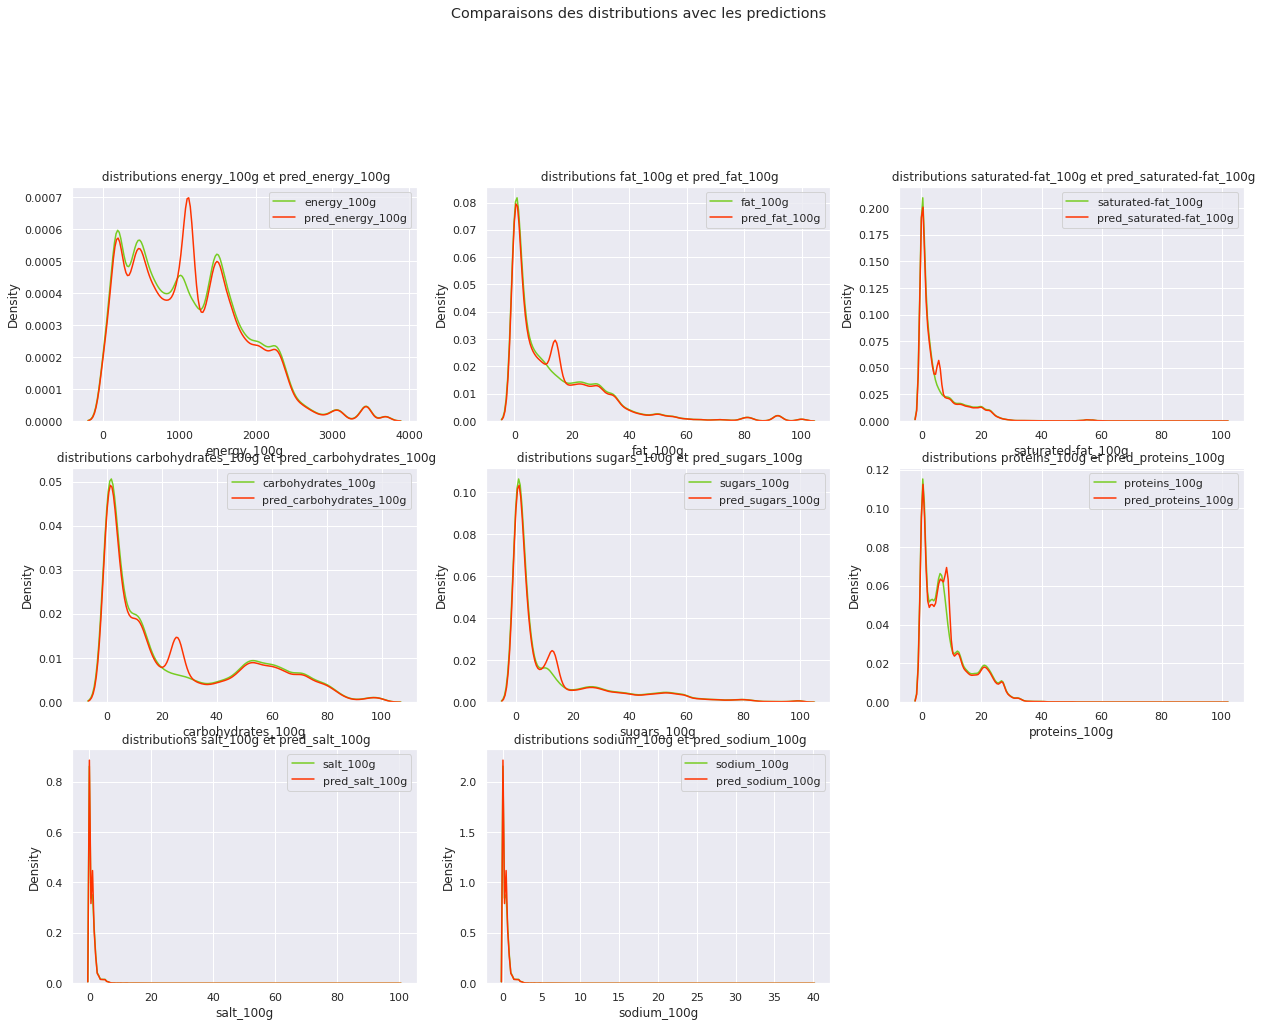

In [ ]:
from scipy import stats
import warnings
fig = plt.figure(figsize=(21,25))
warnings.filterwarnings('ignore')
columntocheck = ['energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g','sodium_100g',]

for i,target in enumerate(columntocheck):  
  fig.add_subplot(5,3,i+1)
  print(target)
  data = []
  target_pred = 'pred_'+target
  sns.kdeplot(target, data = openFoodFile_cleaned, label=target)
  sns.kdeplot(target_pred, data = openFoodFile_cleaned, label=target_pred)
  plt.title(f' distributions {target} et {target_pred}')
  plt.legend()
plt.suptitle("Comparaisons des distributions avec les predictions")
plt.show()  

**comparaisons de protein_100g avec la mediane calculer**

la mediane de fiber correspond egalement !

fiber_100g


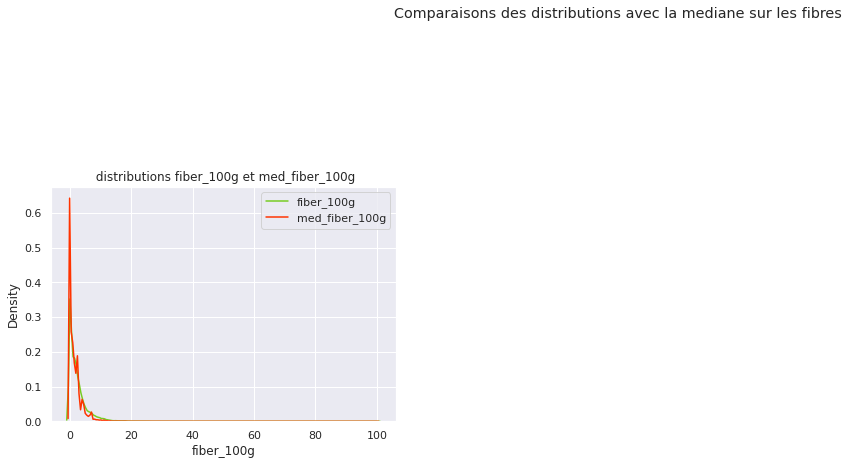

In [ ]:
from scipy import stats
import warnings
fig = plt.figure(figsize=(21,25))
warnings.filterwarnings('ignore')
columntocheck = ['fiber_100g',]

for i,target in enumerate(columntocheck):  
  fig.add_subplot(5,3,i+1)
  print(target)
  data = []
  target_pred = 'med_'+target
  sns.kdeplot(target, data = openFoodFile_cleaned, label=target)
  sns.kdeplot(target_pred, data = openFoodFile_cleaned, label=target_pred)
  plt.title(f' distributions {target} et {target_pred}')
  plt.legend()
plt.suptitle("Comparaisons des distributions avec la mediane sur les fibres")
plt.show()  

<a name="discret"></a>
# discretisation des variables

# nous allons discrétiser la variable <code>nutriscore_score</code> et <code>glucide_score</code> en 5 sous groupes de meme taille pour faciliter l analyse

In [ ]:
openFoodFile_cleaned['categories_nutriscore'] = pd.qcut(openFoodFile_cleaned['nutriscore_score'],5, duplicates='drop')

In [ ]:
openFoodFile_cleaned['categories_gluciscore'] = pd.qcut(openFoodFile_cleaned['glucide_100g'],5, duplicates='drop')

À l'aide d'un tableau croisé des variables categories_gluciscore et categories_nutriscore

On peut remarquer a la troisieme ligne par exemple qu il n y a pas beaucoup d aliments correspondant a la categories_nutriscore 18 40

In [ ]:
pd.crosstab(openFoodFile_cleaned['categories_gluciscore'],openFoodFile_cleaned['categories_nutriscore'])

categories_nutriscore  (-14.001, 1.0]  (1.0, 5.0]  (5.0, 13.0]  (13.0, 18.0]  \
categories_gluciscore                                                          
(-0.001, 0.5]                    7330        6008         7711          7585   
(0.5, 3.65]                      9859        5899         8325          6623   
(3.65, 13.75]                   12142       12277         8698          4760   
(13.75, 36.2]                    4866        5817        11877          5941   
(36.2, 100.0]                    8748        2575         7742          9794   

categories_nutriscore  (18.0, 40.0]  
categories_gluciscore                
(-0.001, 0.5]                  3994  
(0.5, 3.65]                    7053  
(3.65, 13.75]                  1570  
(13.75, 36.2]                 11709  
(36.2, 100.0]                  9238

**Comparer le nutriscore et le glusiscore nous permettra de voir si il y a des liens entre ces categories et pourquoi pas proposer un mix entre ces deux categories**

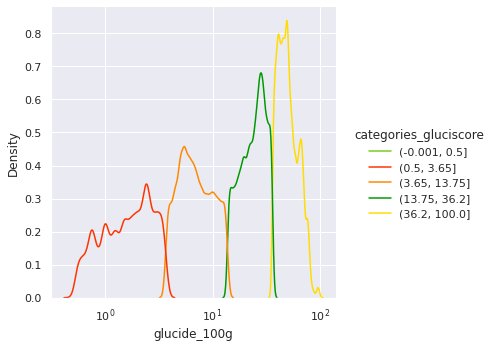

In [ ]:
import warnings
warnings.filterwarnings('ignore')
sns.displot(data=openFoodFile_cleaned,x="glucide_100g",hue="categories_gluciscore",kind="kde", log_scale=True)

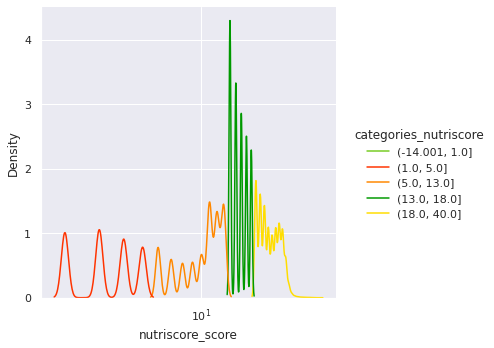

In [ ]:
import warnings
warnings.filterwarnings('ignore')
sns.displot(data=openFoodFile_cleaned,x="nutriscore_score",hue="categories_nutriscore",kind="kde", log_scale=True)

# K-means

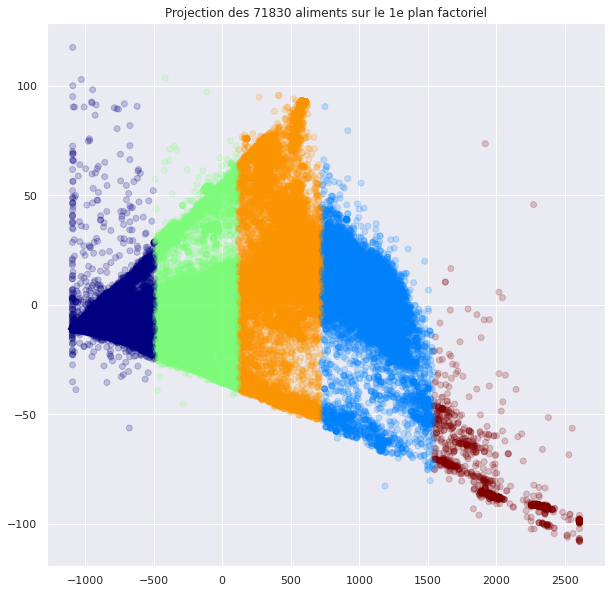

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import decomposition

sns.set_palette(sns.color_palette(colors))
fig = plt.figure(figsize=(10,10))
# Nombre de clusters souhaités
n_clust = 5
# import de l'échantillon
predicted_features = [
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'salt_100g',
 'sodium_100g',
 ]
data = openFoodFile_cleaned[predicted_features].dropna()
# data.head()                                        
# préparation des données pour le clustering
X = data.values
# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
# X_scaled = preprocessing.StandardScaler().fit_transform(X)
# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)
# Récupération des clusters attribués à chaque individu
clusters = km.labels_
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X)
X_projected = pca.transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} aliments sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

On peut donc observer que la repartition des données sur un plan 2d avec k means ne nous aide pas a disctinguées des données qui sorte du lot dans notre jeu de donnees 

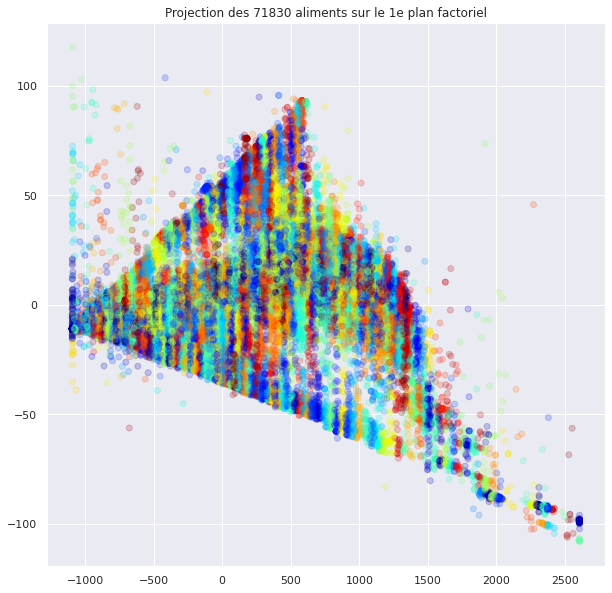

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import decomposition

sns.set_palette(sns.color_palette(colors))
fig = plt.figure(figsize=(10,10))
# Nombre de clusters souhaités
n_clust = 500
# import de l'échantillon
predicted_features = [
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'salt_100g',
 'sodium_100g',
 ]
data = openFoodFile_cleaned[predicted_features].dropna()
# data.head()                                        
# préparation des données pour le clustering
X = data.values
# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
# X_scaled = preprocessing.StandardScaler().fit_transform(X)
# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)
# Récupération des clusters attribués à chaque individu
clusters = km.labels_
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X)
X_projected = pca.transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} aliments sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

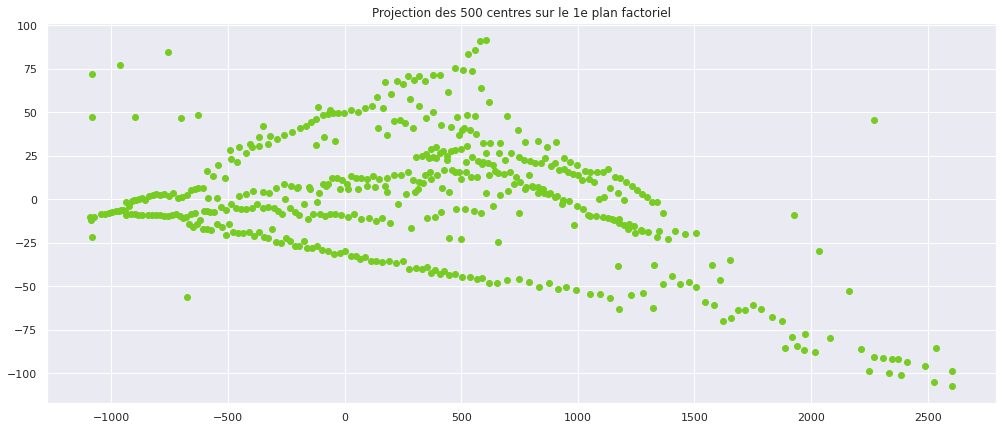

In [ ]:
# example d affichage des 500 positions des centres de classes n_cluster  = 500
plt.figure()
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

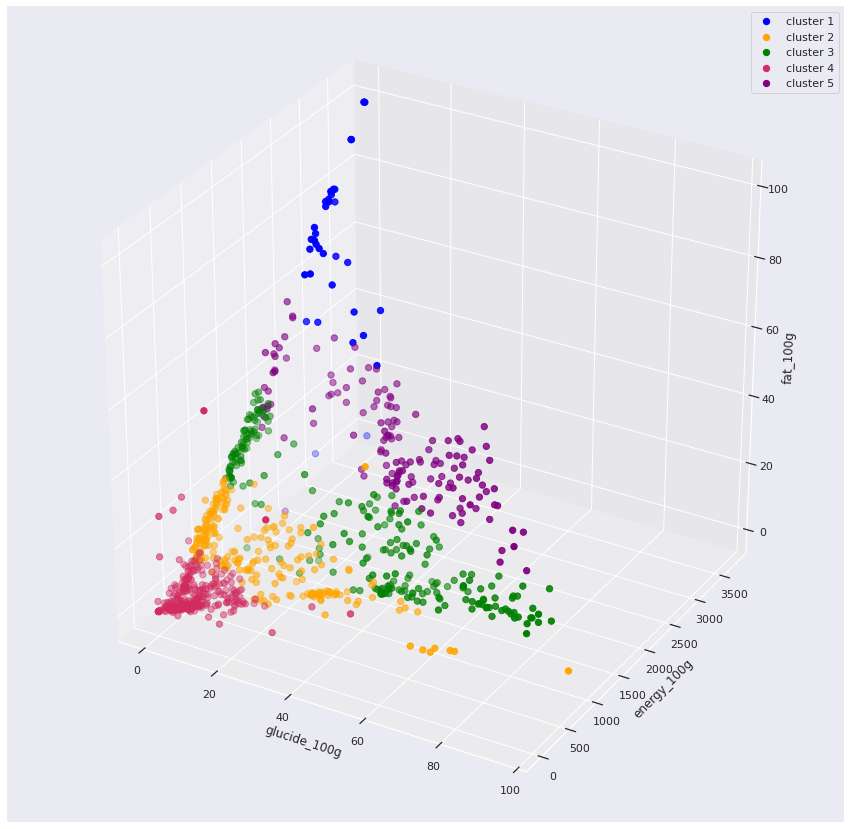

In [ ]:
from sklearn.cluster import KMeans
x =  openFoodFile_cleaned[['glucide_100g','energy_100g', 'fat_100g']].dropna().sample(1000).values
km = KMeans(n_clusters=5)
# km.fit(X)
y_clusters = km.fit_predict(x)
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[y_clusters == 0,0],x[y_clusters == 0,1],x[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 1")
ax.scatter(x[y_clusters == 1,0],x[y_clusters == 1,1],x[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 2")
ax.scatter(x[y_clusters == 2,0],x[y_clusters == 2,1],x[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 3")
ax.scatter(x[y_clusters == 3,0],x[y_clusters == 3,1],x[y_clusters == 3,2], s = 40 , color = '#D12B60', label = "cluster 4")
ax.scatter(x[y_clusters == 4,0],x[y_clusters == 4,1],x[y_clusters == 4,2], s = 40 , color = 'purple', label = "cluster 5")
ax.set_xlabel('glucide_100g')
ax.set_ylabel('energy_100g')
ax.set_zlabel('fat_100g')
ax.legend()
plt.show()

En ajoutant une dimension , nous pouvons vraisemblablement pouvoir isolé certaine categorie d aliments

In [ ]:
openFoodFile_cleaned.to_csv("/content/ShardDrives/MyDrive/formation/nettoyage_fin.csv")